Import Libraries

In [346]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt 
import folium

Load Dataset

In [347]:
# read csv file and save into dataframe df
df = pd.read_csv("Airbnb Listings Bangkok.csv")

df.head()

,Unnamed: 0,id,name,host_id,host_name,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,number_of_reviews_ltm
0,0,27934,Nice room with superb city view,120437,Nuttee,Ratchathewi,13.75983,100.54134,Entire home/apt,1905,3,65,2020-01-06,0.50,2,353,0
1,1,27979,"Easy going landlord,easy place",120541,Emy,Bang Na,13.66818,100.61674,Private room,1316,1,0,NaN,NaN,2,358,0
2,2,28745,modern-style apartment in Bangkok,123784,Familyroom,Bang Kapi,13.75232,100.62402,Private room,800,60,0,NaN,NaN,1,365,0
3,3,35780,Spacious one bedroom at The Kris Condo Bldg. 3,153730,Sirilak,Din Daeng,13.78823,100.57256,Private room,1286,7,2,2022-04-01,0.03,1,323,1
4,4,941865,Suite Room 3 at MetroPoint,610315,Kasem,Bang Kapi,13.76872,100.63338,Private room,1905,1,0,NaN,NaN,3,365,0


Basic Dataset Information

In [348]:
# df.info()

Droping redundant "Unnamed" column

In [349]:
df = df.drop(columns=["Unnamed: 0"])
# df.head()

Find duplicates and handle accordingly

In [350]:
df.duplicated().sum()
# no duplicates

np.int64(0)

Find missing values and handle accordingly

In [351]:
# df.isnull().sum()

In [352]:
# len(df[df["number_of_reviews"] == 0])

In [353]:
# check name column missing values
# df[df["name"].isna()]

In [354]:
# since name are descrptive titles, replace them with placeholder value of "Unknown"
# df["name"].fillna("Unknown", inplace=True)
df.fillna({"name": "Unknown"}, inplace=True)

In [355]:
# double check name column missing values
# df[df["name"].isna()]

# no more name column missing values

In [356]:
# check host_name column missing values
# df[df["host_name"].isna()]

In [357]:
# since host_name is not too important in the analysis, replace them with placeholder value of "Unknown"
df.fillna({"host_name": "Unknown"}, inplace=True)

In [358]:
# double check host_name column missing values
# df[df["host_name"].isna()]

# no more host_name column missing values

In [359]:
# check last_review and reviews_per_month column
# df[df["last_review"].isna() & df["reviews_per_month"].isna()]

In [360]:
# last_review column has 5790 missing values
# reviews_per_month column has 5790 missing values
# above shows 5790 missing values --> btoh last_review and reviews_per_month column falls under the same rows
# last_review can be replaced with placeholder value of "No review" --> since last_review is an object format
# reviews_per_month can be replaced with 0 (no last_review means no reviews were made in any month)

df.fillna({"last_review": "No Review"}, inplace=True)
df.fillna({"reviews_per_month": 0}, inplace=True)

In [361]:
# double check last_review and reviews_per_month column
# df[df["last_review"].isna() & df["reviews_per_month"].isna()]

# no more missing values

In [362]:
# double check all columns for missing values
# df.isnull().sum()

Dataset information after cleaning up missing values

In [363]:
# df.describe()

# Main Topic

Best Areas for AirBnb Investment in Bangkok
<br>
Analyze which neighborhoods have the highest revenue potential

In [364]:
# number of different neighbourhood
# df["neighbourhood"].nunique()

In [365]:
# number of different room_type
# df["room_type"].nunique()

- want to check the difference in prices between the different types of rooms in different neighbourhoods
- logically, the different types of rooms would heva different pricings

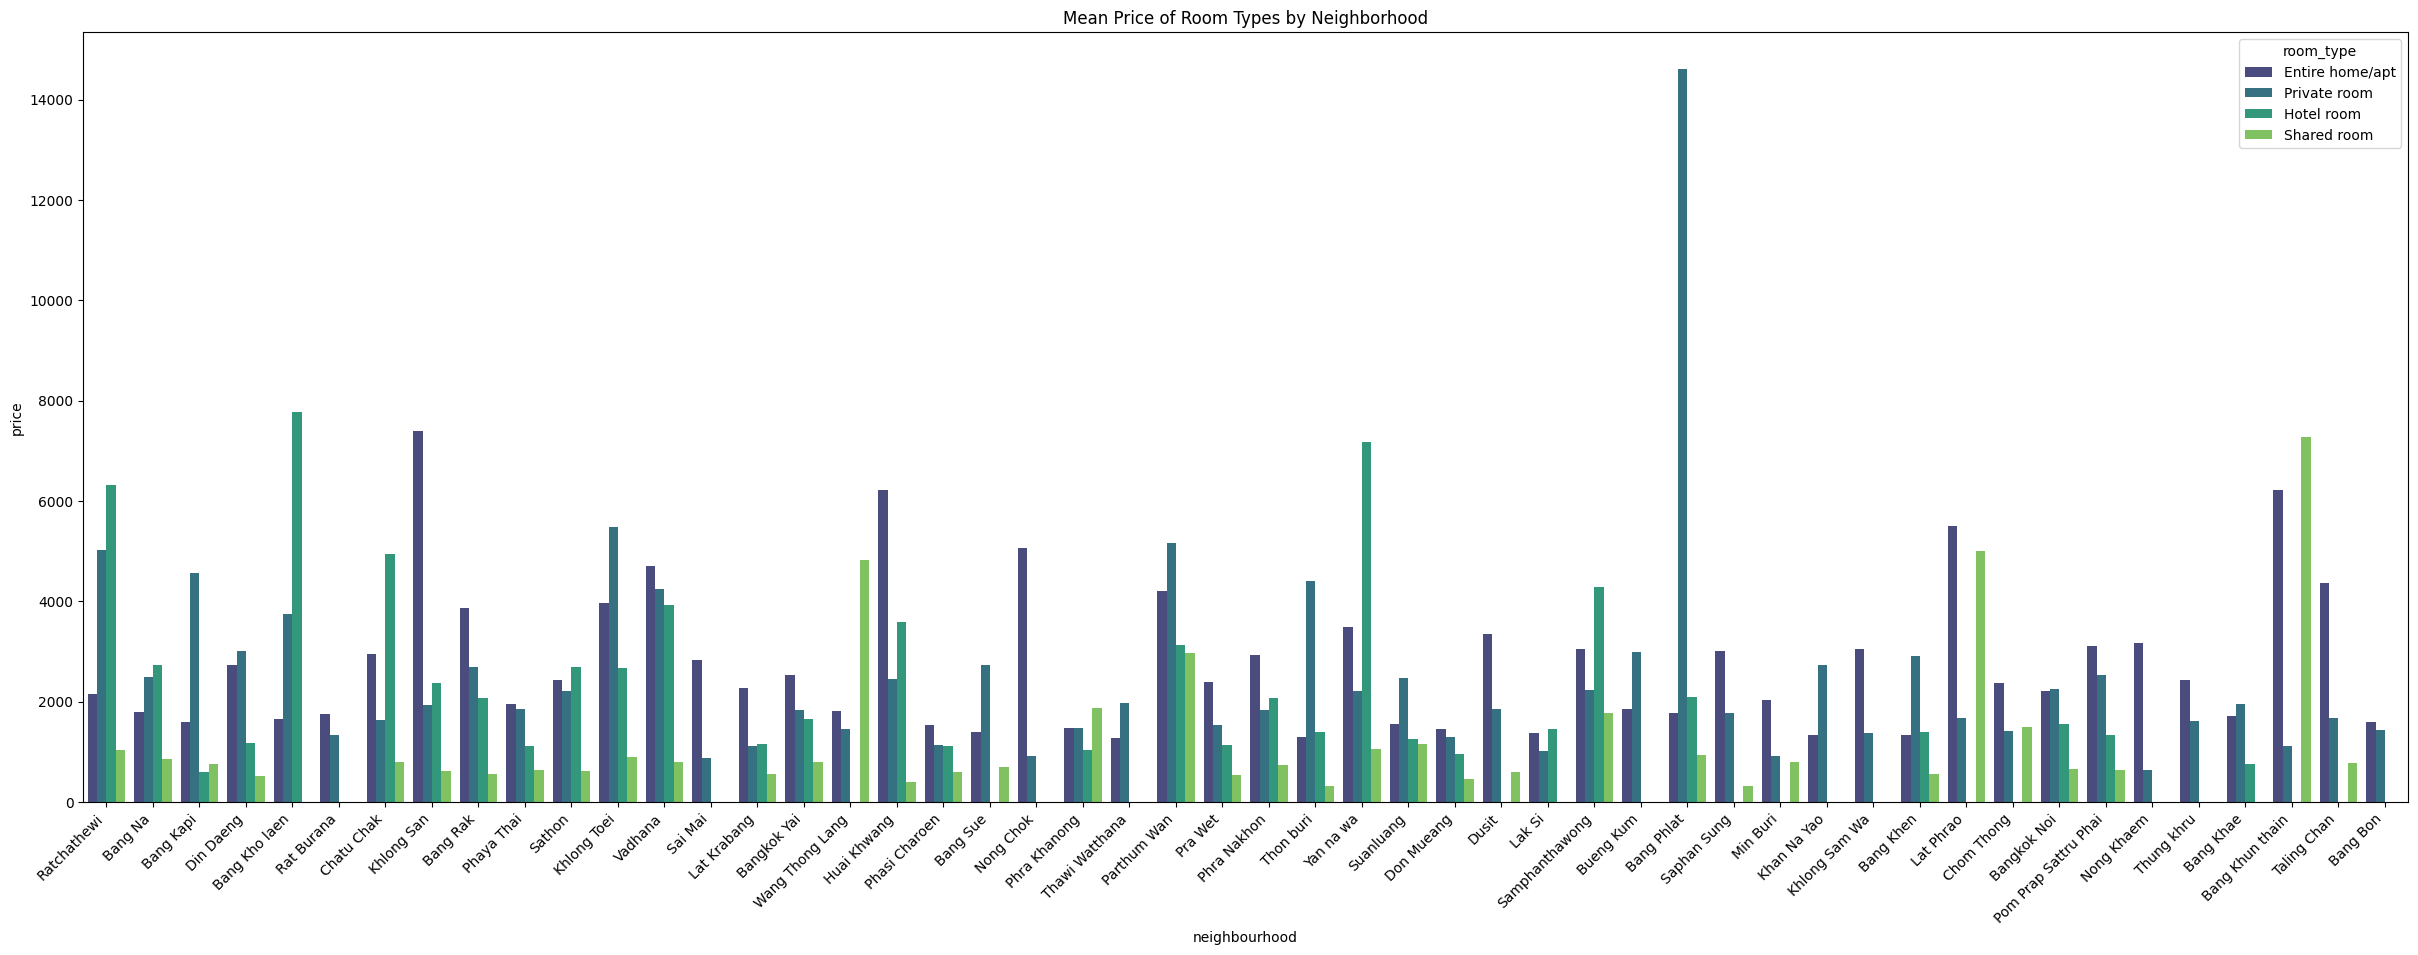

In [366]:
# create graph to see the mean prices of each room_type in each neighbourhood

plt.figure(figsize=(30, 10))
sns.barplot(x = "neighbourhood", y = "price", data = df, hue = "room_type", estimator=np.mean, errorbar= None, palette="viridis")
plt.title("Mean Price of Room Types by Neighborhood")
plt.xticks(rotation=45, ha="right");

- too many neighbourhoods --> difficult to visualise
- separate into different zones based on enighbourhood median longitude nad latitude (central, northeast, northwest, southeast, southwest)

In [367]:
neighborhood_medians = df.groupby("neighbourhood")[["latitude", "longitude"]].median().reset_index()

In [368]:
# find the median of latitude and longitude
median_lat = df["latitude"].median()    # to divide north vs south
median_lon = df["longitude"].median()   # to divide east vs west

# create function to assign regions based on lat lon
def assign_region(lat, lon):

    lat_q1, lat_q3 = df["latitude"].quantile([0.25, 0.75])
    lon_q1, lon_q3 = df["longitude"].quantile([0.25, 0.75])
    iqr_lat = lat_q3 - lat_q1
    iqr_lon = lon_q3 - lon_q1
    
    # Adjust Central Region
    central_lat_min = lat_q1
    central_lat_max = lat_q3
    central_lon_min = lon_q1
    central_lon_max = lon_q3
    
    if central_lat_min <= lat <= central_lat_max and central_lon_min <= lon <= central_lon_max: # central area range
        return "Central"
    elif lat >= median_lat and lon > median_lon:
        return "Northeast"
    elif lat >= median_lat and lon <= median_lon:
        return "Northwest"
    elif lat < median_lat and lon > median_lon:
        return "Southeast"
    elif lat < median_lat and lon <= median_lon:
        return "Southwest"


In [369]:
lat_q1, lat_q3 = df["latitude"].quantile([0.25, 0.75])
lon_q1, lon_q3 = df["longitude"].quantile([0.25, 0.75])
iqr_lat = lat_q3 - lat_q1
iqr_lon = lon_q3 - lon_q1

# print("Latitude IQR: " + str(iqr_lat))
# print("Longitude IQR: " + str(iqr_lon))

In [370]:
neighborhood_medians["region"] = neighborhood_medians.apply(
    lambda row: assign_region(row["latitude"], row["longitude"]), axis=1
)


In [371]:
df = df.merge(neighborhood_medians[["neighbourhood", "region"]], on="neighbourhood", how="left")
# df.head()

In [372]:
# check number of entries for each region
df["region"].value_counts()

region
Central      5819
Northeast    3245
Southwest    3151
Northwest    1936
Southeast    1703
Name: count, dtype: int64

create map for distribution of listings per region

In [373]:
# Define a color mapping for your regions
region_colors = {
    "Central": "red",
    "Northeast": "blue",
    "Southwest": "green",
    "Northwest": "purple",
    "Southeast": "orange"
}

# Create a base map centered around the average coordinates
map_center = [df["latitude"].mean(), df["longitude"].mean()]
m = folium.Map(location=map_center, zoom_start=12)

# Add points for each listing
for _, row in df.iterrows():
    folium.CircleMarker(
        location=[row["latitude"], row["longitude"]],
        radius=2,
        color=region_colors.get(row["region"], "black"),
        fill=True,
        fill_color=region_colors.get(row["region"], "black"),
        fill_opacity=0.6,
    ).add_to(m)

# Show the map
# m

In [374]:
df["neighbourhood"].value_counts()

neighbourhood
Vadhana                 2153
Khlong Toei             2097
Huai Khwang             1125
Ratchathewi             1114
Bang Rak                 827
Sathon                   809
Phra Nakhon              619
Phra Khanong             558
Chatu Chak               548
Bang Na                  458
Parthum Wan              455
Din Daeng                444
Phaya Thai               422
Suanluang                382
Khlong San               357
Bang Kapi                260
Bang Sue                 250
Bang Phlat               217
Yan na wa                200
Thon buri                182
Don Mueang               167
Pra Wet                  156
Phasi Charoen            155
Bangkok Noi              152
Lat Krabang              149
Bang Kho laen            140
Lak Si                   126
Pom Prap Sattru Phai     123
Bang Khen                116
Samphanthawong           114
Wang Thong Lang          100
Bang Khae                 92
Dusit                     91
Bangkok Yai               90


In [375]:
df.head()

,id,name,host_id,host_name,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,number_of_reviews_ltm,region
0,27934,Nice room with superb city view,120437,Nuttee,Ratchathewi,13.75983,100.54134,Entire home/apt,1905,3,65,2020-01-06,0.50,2,353,0,Central
1,27979,"Easy going landlord,easy place",120541,Emy,Bang Na,13.66818,100.61674,Private room,1316,1,0,No Review,0.00,2,358,0,Southeast
2,28745,modern-style apartment in Bangkok,123784,Familyroom,Bang Kapi,13.75232,100.62402,Private room,800,60,0,No Review,0.00,1,365,0,Northeast
3,35780,Spacious one bedroom at The Kris Condo Bldg. 3,153730,Sirilak,Din Daeng,13.78823,100.57256,Private room,1286,7,2,2022-04-01,0.03,1,323,1,Northeast
4,941865,Suite Room 3 at MetroPoint,610315,Kasem,Bang Kapi,13.76872,100.63338,Private room,1905,1,0,No Review,0.00,3,365,0,Northeast


clean up room_type categorisation

In [376]:
df["region"].value_counts()

region
Central      5819
Northeast    3245
Southwest    3151
Northwest    1936
Southeast    1703
Name: count, dtype: int64

In [377]:
# df[df["room_type"] == "Entire home/apt"]

In [378]:
# df[df["room_type"] == "Hotel room"]

In [379]:
# df[df["room_type"] == "Shared room"]

In [380]:
# df[df["room_type"] == "Private room"]

In [381]:
eha_keywords = ["house", "home", "apartment", "apt", "condo", "villa"] # keywords for entire home/apt
hr_keywords = ["hotel"]    # keywords for hotel room
sr_keywords = ["dorm", "hostel", "capsule"] # keywords for shared room
# private room will logically be the rest

In [382]:
for index, row in df.iterrows():
    if any(keyword in row["name"].lower() for keyword in eha_keywords):  # Entire home/apt
        df.loc[index, "room_type"] = "Entire home/apt"
    elif any(keyword in row["name"].lower() for keyword in hr_keywords):  # Hotel room
        df.loc[index, "room_type"] = "Hotel room"
    elif any(keyword in row["name"].lower() for keyword in sr_keywords):  # Shared room
        df.loc[index, "room_type"] = "Shared room"
    else:  
        pass

In [383]:
# df[(df["name"].str.contains("Apartment", case=False, na=False)) & (df["room_type"] != "Entire home/apt")]

In [384]:
# check value counts
df["room_type"].value_counts()

room_type
Entire home/apt    10280
Private room        4013
Hotel room           838
Shared room          723
Name: count, dtype: int64

note that the amount for hotel increased mostly because some hotel rooms are incorrectly miscategorised as a private room

In [385]:
# create sub dataframes based on region
central_df = df[df["region"] == "Central"]
northeast_df = df[df["region"] == "Northeast"]
southwest_df = df[df["region"] == "Southwest"]
northwest_df = df[df["region"] == "Northwest"]
southeast_df = df[df["region"] == "Southeast"]

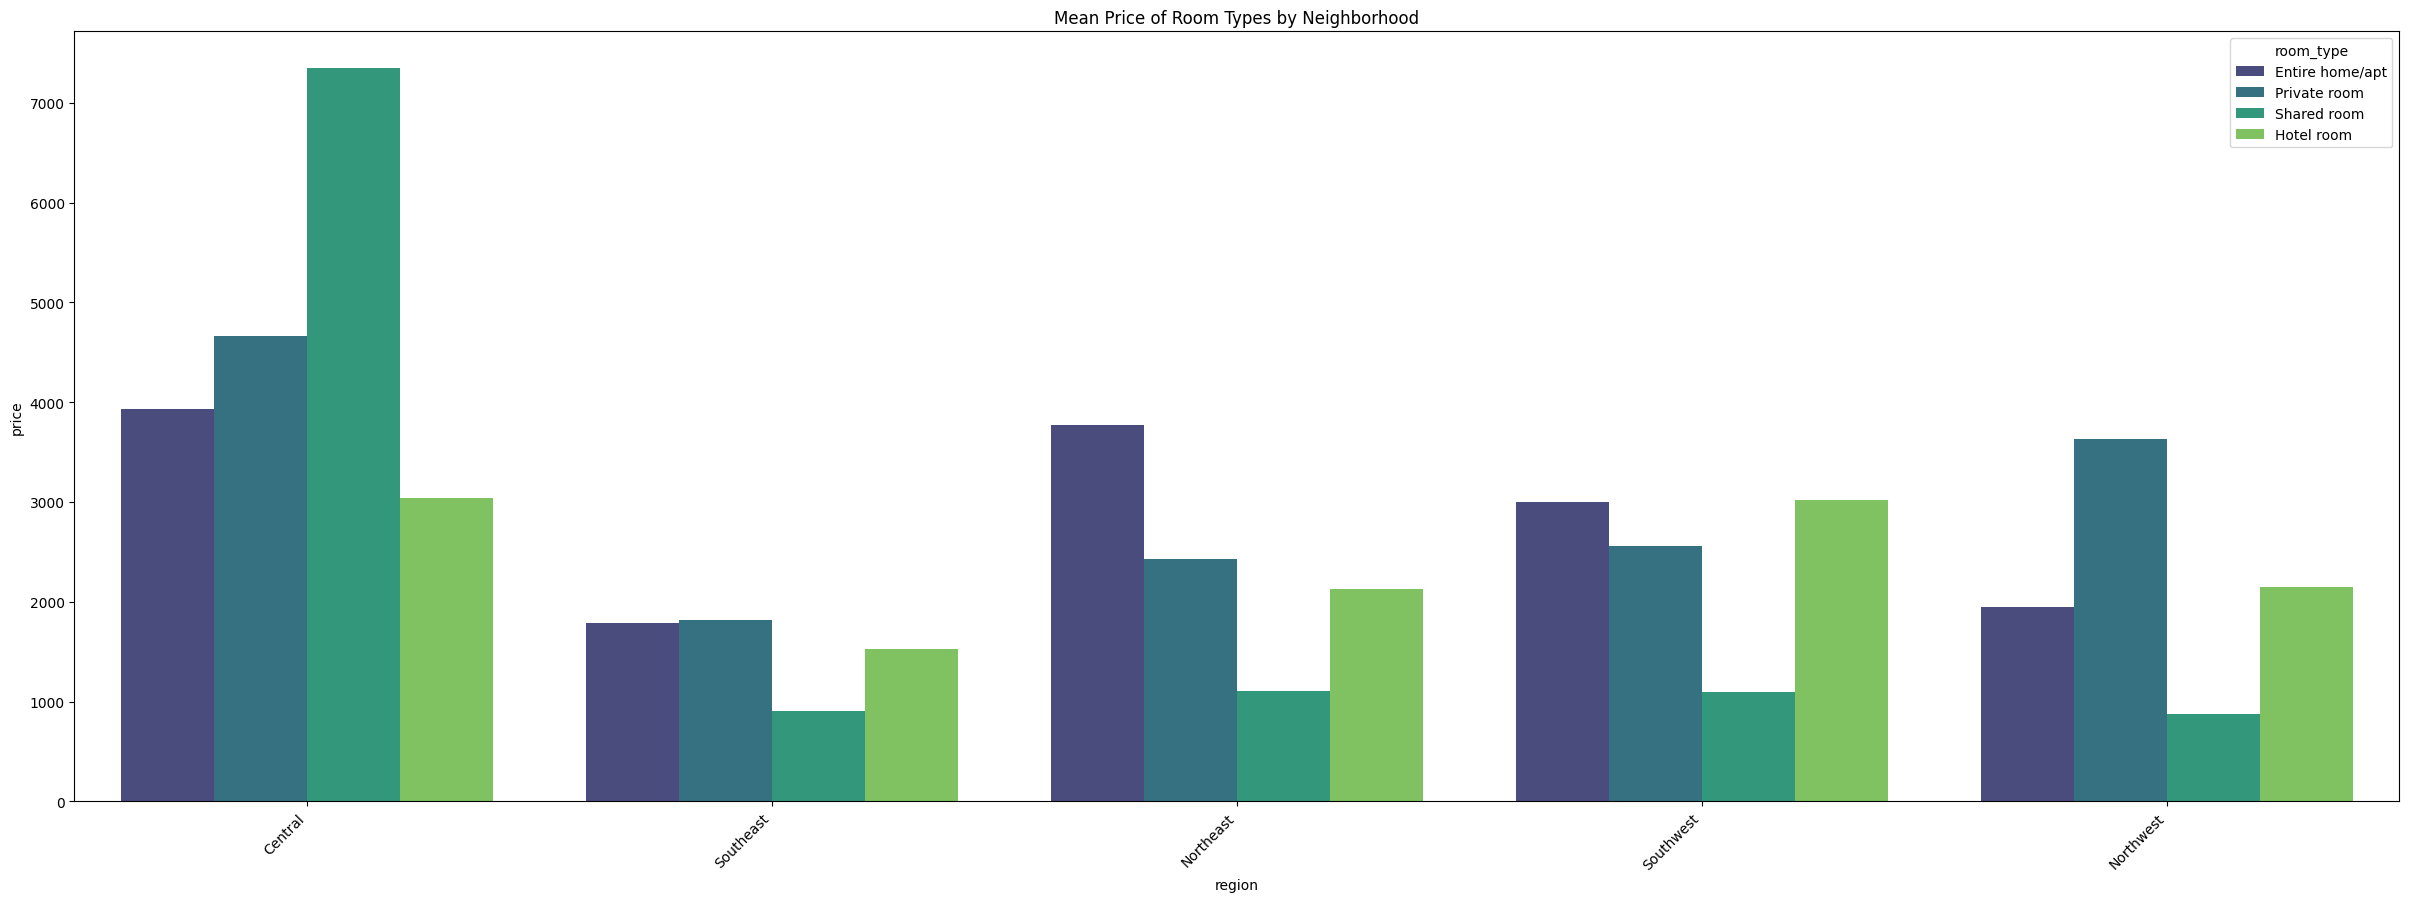

In [386]:
# create graph to see the mean prices of each room_type in each zonal area - for cleaning purposes

plt.figure(figsize=(30, 10))
sns.barplot(x = "region", y = "price", data = df, hue = "room_type", estimator=np.mean, errorbar= None, palette="viridis")
plt.title("Mean Price of Room Types by Neighborhood")
plt.xticks(rotation=45, ha="right");

In [387]:
df

,id,name,host_id,host_name,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,number_of_reviews_ltm,region
0,27934,Nice room with superb city view,120437,Nuttee,Ratchathewi,13.759830,100.541340,Entire home/apt,1905,3,65,2020-01-06,0.50,2,353,0,Central
1,27979,"Easy going landlord,easy place",120541,Emy,Bang Na,13.668180,100.616740,Private room,1316,1,0,No Review,0.00,2,358,0,Southeast
2,28745,modern-style apartment in Bangkok,123784,Familyroom,Bang Kapi,13.752320,100.624020,Entire home/apt,800,60,0,No Review,0.00,1,365,0,Northeast
3,35780,Spacious one bedroom at The Kris Condo Bldg. 3,153730,Sirilak,Din Daeng,13.788230,100.572560,Entire home/apt,1286,7,2,2022-04-01,0.03,1,323,1,Northeast
4,941865,Suite Room 3 at MetroPoint,610315,Kasem,Bang Kapi,13.768720,100.633380,Private room,1905,1,0,No Review,0.00,3,365,0,Northeast
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15849,790465040741092826,素坤逸核心两房公寓42楼，靠近BTSon nut/无边天际泳池观赏曼谷夜景/出门当地美食街,94899359,Renee,Pra Wet,13.715132,100.653458,Private room,2298,28,0,No Review,0.00,1,362,0,Southeast
15850,790474503157243541,Euro LuxuryHotel PratunamMKt TripleBdNrShoping...,491526222,Phakhamon,Ratchathewi,13.753052,100.538738,Hotel room,1429,1,0,No Review,0.00,14,365,0,Central
15851,790475335086864240,Euro LuxuryHotel PratunamMKt TwinBedNrShopingArea,491526222,Phakhamon,Ratchathewi,13.753169,100.538700,Hotel room,1214,1,0,No Review,0.00,14,365,0,Central
15852,790475546213717328,Euro LuxuryHotel PratunamMKt TwinBedNrShopingArea,491526222,Phakhamon,Ratchathewi,13.754789,100.538757,Hotel room,1214,1,0,No Review,0.00,14,365,0,Central


# Central

In [388]:
# central_df.head()

In [389]:
# central_df["neighbourhood"].value_counts()

In [390]:
# central_df["room_type"].value_counts()

In [391]:
# room_type price mean
# central_df.groupby("room_type")["price"].mean()

In [392]:
# # mean price of room_types in central
# plt.figure(figsize=(7, 7))
# sns.barplot(x = "room_type", y = "price", hue = "room_type", data = central_df, estimator=np.mean, errorbar= None, palette="Set2")
# plt.title("Mean Price of Room Types in Central Area")
# plt.xlabel("Room Types")
# plt.ylabel("Price Mean")

In [393]:
# room_type price median
# central_df.groupby("room_type")["price"].median()

In [394]:
# # median price of room_types in central
# plt.figure(figsize=(7, 7))
# sns.barplot(x = "room_type", y = "price", hue = "room_type", data = central_df, estimator=np.median, errorbar= None, palette="viridis")
# plt.title("Median Price of Room Types in Central Area")
# plt.xlabel("Room Types")
# plt.ylabel("Price Mean")

In [395]:
# # create boxplot to see distribution of room_type price side by side
# plt.figure(figsize=(7, 7))
# sns.boxplot(x = "room_type", y = "price", hue = "room_type", data = central_df, palette="viridis")
# plt.title("Distribution of Prices by Room Types in Central Area")
# plt.xlabel("Room Types")
# plt.ylabel("Price")

not normal distribution
<br>
there are outliers that needs to be addressed

In [396]:
# create dataframes for each room_type in central_df
central_eha = central_df[central_df["room_type"] == "Entire home/apt"]
central_pr = central_df[central_df["room_type"] == "Private room"]
central_hr = central_df[central_df["room_type"] == "Hotel room"]
central_sr = central_df[central_df["room_type"] == "Shared room"]

In [397]:
# check if dataframes created correctly
# len(central_eha)
# len(central_pr)
# len(central_hr)
# len(central_sr)

### entire home/apt

In [398]:
# len(central_eha)

In [399]:
# central_eha.head()

In [400]:
# central_eha.sort_values(by="price", ascending = False).head()

In [401]:
# # create histogram to see the distribution of price
# plt.figure(figsize=(10, 7))
# sns.histplot(data = central_eha, x="price", color = "#006884")
# plt.title("Distribution of Entire Home/Apt Prices in Central Area")
# plt.xlabel("Price")
# plt.ylabel("Count")
# plt.show()

remove extreme outliers manually

In [402]:
# central_eha.sort_values(by="price", ascending = False).head(10)

In [403]:
central_eha = central_eha[central_eha["price"] < 200000]

In [404]:
# plt.figure(figsize=(10, 7))
# sns.histplot(data = central_eha, x="price", color = "#006884")
# plt.title("Distribution of Entire Home/Apt Prices in Central Area")
# plt.xlabel("Price")
# plt.ylabel("Count")
# plt.show()

In [405]:
# central_eha.sort_values(by="price", ascending = False).head(10)

calculate iqr

In [406]:
# function to find the price outliers
def price_outlier(df):
    Q1 = df["price"].quantile(0.25)
    Q3 = df["price"].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    lower_outliers = df[df["price"] < lower_bound]
    upper_outliers = df[df["price"] > upper_bound]

    return lower_outliers, upper_outliers, lower_bound, upper_bound

In [407]:
# len(price_outlier(central_eha)[0])
# no lower outliers

In [408]:
# len(price_outlier(central_eha)[1])
# 341 upper outliers

remove outliers based on iqr

In [409]:
central_eha_cleaned = central_eha[central_eha["price"] < price_outlier(central_eha)[-1]]

In [410]:
# # histogram of cleaned central entire home/apt price distribution
# plt.figure(figsize=(10, 7))
# sns.histplot(data = central_eha_cleaned, x="price", color = "#006884")
# plt.title("Distribution of Entire Home/Apt Prices in Central Area")
# plt.xlabel("Price")
# plt.ylabel("Count")
# plt.show()

### hotel room

In [411]:
# len(central_hr)

In [412]:
# central_hr.head()

In [413]:
# central_hr.sort_values(by = "price", ascending = False).head()

In [414]:
# # create histogram to see the distribution of price
# plt.figure(figsize=(10, 7))
# sns.histplot(data = central_hr, x="price", color = "#006884")
# plt.title("Distribution of Hotel Room Prices in Central Area")
# plt.xlabel("Price")
# plt.ylabel("Count")
# plt.show()

remove extreme outliers

In [415]:
central_hr = central_hr[central_hr["price"] < 15000]

In [416]:
# plt.figure(figsize=(10, 7))
# sns.histplot(data = central_hr, x="price", color = "#006884")
# plt.title("Distribution of Hotel Room Prices in Central Area")
# plt.xlabel("Price")
# plt.ylabel("Count")
# plt.show()

In [417]:
# len(price_outlier(central_hr)[0])
# len(price_outlier(central_hr)[1])

remove outliers based on iqr

In [418]:
central_hr_cleaned = central_hr[central_hr["price"] < price_outlier(central_hr)[-1]]

In [419]:
# # cleaned price distribtution
# plt.figure(figsize=(10, 7))
# sns.histplot(data = central_hr_cleaned, x="price", color = "#006884")
# plt.title("Distribution of Hotel Room Prices in Central Area")
# plt.xlabel("Price")
# plt.ylabel("Count")
# plt.show()

### private room

In [420]:
# len(central_pr)

In [421]:
# central_pr.head()

In [422]:
# central_pr.sort_values(by = "price", ascending = False).head()

In [423]:
# # histogram to see raw distribution
# plt.figure(figsize=(10, 7))
# sns.histplot(data = central_pr, x="price", color = "#006884")
# plt.title("Distribution of Private Room Prices in Central Area")
# plt.xlabel("Price")
# plt.ylabel("Count")
# plt.show()

remove extreme outliers

In [424]:
central_pr = central_pr[central_pr["price"] < 50000]

In [425]:
# plt.figure(figsize=(10, 7))
# sns.histplot(data = central_pr, x="price", color = "#006884")
# plt.title("Distribution of Private Room Prices in Central Area")
# plt.xlabel("Price")
# plt.ylabel("Count")
# plt.show()

In [426]:
# len(price_outlier(central_pr)[0])
# len(price_outlier(central_pr)[1])

remove outliers based on iqr

In [427]:
central_pr_cleaned = central_pr[central_pr["price"] < price_outlier(central_pr)[-1]]

In [428]:
# # cleaned distribution
# plt.figure(figsize=(10, 7))
# sns.histplot(data = central_pr_cleaned, x="price", color = "#006884")
# plt.title("Distribution of Private Room Prices in Central Area")
# plt.xlabel("Price")
# plt.ylabel("Count")
# plt.show()

### shared room

In [429]:
# len(central_sr)

In [430]:
# central_sr.head()

In [431]:
# central_sr.sort_values(by = "price", ascending = False).head()

In [432]:
# # raw data distribution
# plt.figure(figsize=(10, 7))
# sns.histplot(data = central_sr, x="price", color = "#006884")
# plt.title("Distribution of Shared Room Prices in Central Area")
# plt.xlabel("Price")
# plt.ylabel("Count")
# plt.show()

remove extreme outliers

In [433]:
central_sr = central_sr[central_sr["price"] < 10000]

In [434]:
# plt.figure(figsize=(10, 7))
# sns.histplot(data = central_sr, x="price", color = "#006884")
# plt.title("Distribution of Shared Room Prices in Central Area")
# plt.xlabel("Price")
# plt.ylabel("Count")
# plt.show()

In [435]:
# len(price_outlier(central_sr)[0])
# len(price_outlier(central_sr)[1])

remove outliers based on iqr

In [436]:
central_sr_cleaned = central_sr[central_sr["price"] < price_outlier(central_sr)[-1]]

In [437]:
# # cleaned data distribution
# plt.figure(figsize=(10, 7))
# sns.histplot(data = central_sr_cleaned, x="price", color = "#006884")
# plt.title("Distribution of Shared Room Prices in Central Area")
# plt.xlabel("Price")
# plt.ylabel("Count")
# plt.show()

#### combine all cleaned room_type dataframes for central

In [438]:
central_df_cleaned = pd.concat([central_eha_cleaned, central_hr_cleaned, central_pr_cleaned, central_sr_cleaned])

In [439]:
# len(central_df_cleaned)

In [440]:
# # double check if concat worked properly
# len(central_eha_cleaned) + len(central_hr_cleaned) + len(central_pr_cleaned) + len(central_sr_cleaned)

Text(0, 0.5, 'Price')

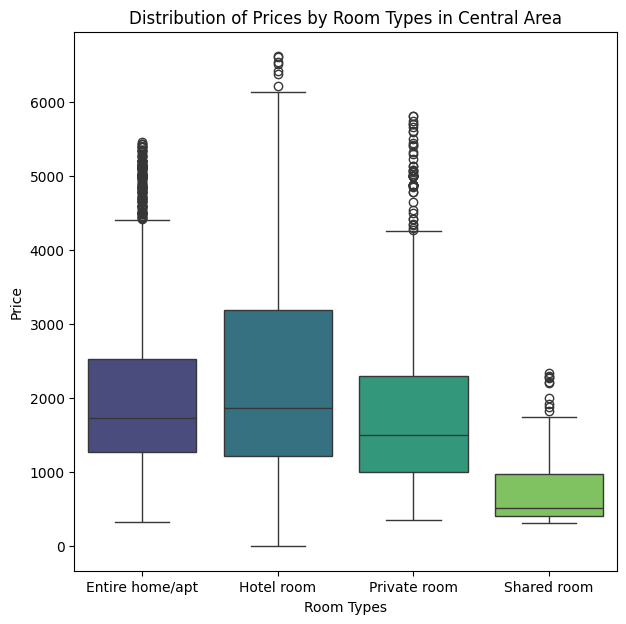

In [441]:
# clean boxplot to see distribution of room_type price side by side
plt.figure(figsize=(7, 7))
sns.boxplot(x = "room_type", y = "price", hue = "room_type", data = central_df_cleaned, palette="viridis")
plt.title("Distribution of Prices by Room Types in Central Area")
plt.xlabel("Room Types")
plt.ylabel("Price")

# Northwest

In [442]:
# len(northwest_df)

In [443]:
# northwest_df.head()

In [444]:
# northwest_df["neighbourhood"].value_counts()

In [445]:
# northwest_df["room_type"].value_counts()

In [446]:
# room_type price mean
# northwest_df.groupby("room_type")["price"].mean()

In [447]:
# # mean price of room_types in northwest
# plt.figure(figsize=(7, 7))
# sns.barplot(x = "room_type", y = "price", hue = "room_type", data = northwest_df, estimator=np.mean, errorbar= None, palette="viridis")
# plt.title("Mean Price of Room Types in Northwest Area")
# plt.xlabel("Room Types")
# plt.ylabel("Price Mean")

In [448]:
# # room_type price median
# northwest_df.groupby("room_type")["price"].median()

In [449]:
# # median price of room_types in northwest
# plt.figure(figsize=(7, 7))
# sns.barplot(x = "room_type", y = "price", hue = "room_type", data = northwest_df, estimator=np.median, errorbar= None, palette="viridis")
# plt.title("Median Price of Room Types in Northwest Area")
# plt.xlabel("Room Types")
# plt.ylabel("Price Mean")


In [450]:
# # create boxplot to see distribution of room_type price side by side
# plt.figure(figsize=(7, 7))
# sns.boxplot(x = "room_type", y = "price", hue = "room_type", data = northwest_df, palette="viridis")
# plt.title("Distribution of Prices by Room Types in Northwest Area")
# plt.xlabel("Room Types")
# plt.ylabel("Price")

not normally distributed
<br>
outliers need to be addressed

In [451]:
# create dataframes for each room_type in northwest_df
nw_eha = northwest_df[northwest_df["room_type"] == "Entire home/apt"]
nw_pr = northwest_df[northwest_df["room_type"] == "Private room"]
nw_hr = northwest_df[northwest_df["room_type"] == "Hotel room"]
nw_sr = northwest_df[northwest_df["room_type"] == "Shared room"]

### entire home/apt

In [452]:
# len(nw_eha)

In [453]:
# nw_eha.head()

In [454]:
# nw_eha.sort_values(by = "price", ascending = False).head()

In [455]:
# # raw data histogram for prices of entire home/apt in northwest area
# plt.figure(figsize=(10, 7))
# sns.histplot(data = nw_eha, x="price", color = "#006884")
# plt.title("Distribution of Entire Home/Apt Prices in Northwest Area")
# plt.xlabel("Price")
# plt.ylabel("Count")
# plt.show()

remove extreme outliers

In [456]:
nw_eha = nw_eha[nw_eha["price"] < 15000]

In [457]:
# plt.figure(figsize=(10, 7))
# sns.histplot(data = nw_eha, x="price", color = "#006884")
# plt.title("Distribution of Entire Home/Apt Prices in Northwest Area")
# plt.xlabel("Price")
# plt.ylabel("Count")
# plt.show()

In [458]:
len(price_outlier(nw_eha)[0])
len(price_outlier(nw_eha)[1])

80

remove outliers based on iqr

In [459]:
nw_eha_cleaned = nw_eha[nw_eha["price"] < price_outlier(nw_eha)[-1]]

In [460]:
# # cleaned distribution of price
# plt.figure(figsize=(10, 7))
# sns.histplot(data = nw_eha_cleaned, x="price", color = "#006884")
# plt.title("Distribution of Entire Home/Apt Prices in Northwest Area")
# plt.xlabel("Price")
# plt.ylabel("Count")
# plt.show()

### hotel room

In [461]:
# len(nw_hr)

In [462]:
# nw_hr.head()

In [463]:
# nw_hr.sort_values(by = "price", ascending = False).head()

In [464]:
# # raw data histogram
# plt.figure(figsize=(10, 7))
# sns.histplot(data = nw_hr, x="price", color = "#006884")
# plt.title("Distribution of Hotel Room Prices in Northwest Area")
# plt.xlabel("Price")
# plt.ylabel("Count")
# plt.show()

remove extreme outliers

In [465]:
nw_hr = nw_hr[nw_hr["price"] < 12000]

In [466]:
# plt.figure(figsize=(10, 7))
# sns.histplot(data = nw_hr, x="price", color = "#006884")
# plt.title("Distribution of Hotel Room Prices in Northwest Area")
# plt.xlabel("Price")
# plt.ylabel("Count")
# plt.show()

In [467]:
# len(price_outlier(nw_hr)[0])
# len(price_outlier(nw_hr)[1])

remove outliers based on iqr

In [468]:
nw_hr_cleaned = nw_hr[nw_hr["price"] < price_outlier(nw_hr)[-1]]

In [469]:
# # cleaned distribution
# plt.figure(figsize=(10, 7))
# sns.histplot(data = nw_hr_cleaned, x="price", color = "#006884")
# plt.title("Distribution of Hotel Room Prices in Northwest Area")
# plt.xlabel("Price")
# plt.ylabel("Count")
# plt.show()

### private room

In [470]:
# len(nw_pr)

In [471]:
# nw_pr.head()

In [472]:
# nw_pr.sort_values(by = "price", ascending = False).head()

In [473]:
# # raw data histogram
# plt.figure(figsize=(10, 7))
# sns.histplot(data = nw_pr, x="price", color = "#006884")
# plt.title("Distribution of Private Room Prices in Northwest Area")
# plt.xlabel("Price")
# plt.ylabel("Count")
# plt.show()

remove extreme outliers

In [474]:
nw_pr = nw_pr[nw_pr["price"] < 100000]

In [475]:
# plt.figure(figsize=(10, 7))
# sns.histplot(data = nw_pr, x="price", color = "#006884")
# plt.title("Distribution of Private Room Prices in Northwest Area")
# plt.xlabel("Price")
# plt.ylabel("Count")
# plt.show()

In [476]:
# len(price_outlier(nw_pr)[0])
# len(price_outlier(nw_pr)[1])

remove outliers based on iqr

In [477]:
nw_pr_cleaned = nw_pr[nw_pr["price"] < price_outlier(nw_pr)[-1]]

In [478]:
# # cleaned distribution
# plt.figure(figsize=(10, 7))
# sns.histplot(data = nw_pr_cleaned, x="price", color = "#006884")
# plt.title("Distribution of Private Room Prices in Northwest Area")
# plt.xlabel("Price")
# plt.ylabel("Count")
# plt.show()

### shared room

In [479]:
# len(nw_sr)

In [480]:
# nw_sr.head()

In [481]:
# # raw data distribution
# plt.figure(figsize=(10, 7))
# sns.histplot(data = nw_sr, x="price", color = "#006884")
# plt.title("Distribution of Shared Room Prices in Northwest Area")
# plt.xlabel("Price")
# plt.ylabel("Count")
# plt.show()

remove extreme outliers

In [482]:
nw_sr = nw_sr[nw_sr["price"] < 7500]

In [483]:
# plt.figure(figsize=(10, 7))
# sns.histplot(data = nw_sr, x="price", color = "#006884")
# plt.title("Distribution of Shared Room Prices in Northwest Area")
# plt.xlabel("Price")
# plt.ylabel("Count")
# plt.show()

In [484]:
# len(price_outlier(nw_sr)[0])
# len(price_outlier(nw_sr)[1])

remove outliers based on iqr

In [485]:
nw_sr_cleaned = nw_sr[nw_sr["price"] < price_outlier(nw_sr)[-1]]

In [486]:
# # cleaned distribution
# plt.figure(figsize=(10, 7))
# sns.histplot(data = nw_sr_cleaned, x="price", color = "#006884")
# plt.title("Distribution of Shared Room Prices in Northwest Area")
# plt.xlabel("Price")
# plt.ylabel("Count")
# plt.show()

#### combine all cleaned room_type dataframes for northwest

In [487]:
northwest_df_cleaned = pd.concat([nw_eha_cleaned, nw_hr_cleaned, nw_pr_cleaned, nw_sr_cleaned])

In [488]:
# len(northwest_df_cleaned)

In [489]:
# double check if concat worked properly
# len(nw_eha_cleaned) + len(nw_hr_cleaned) + len(nw_pr_cleaned) + len(nw_sr_cleaned)

Text(0, 0.5, 'Price')

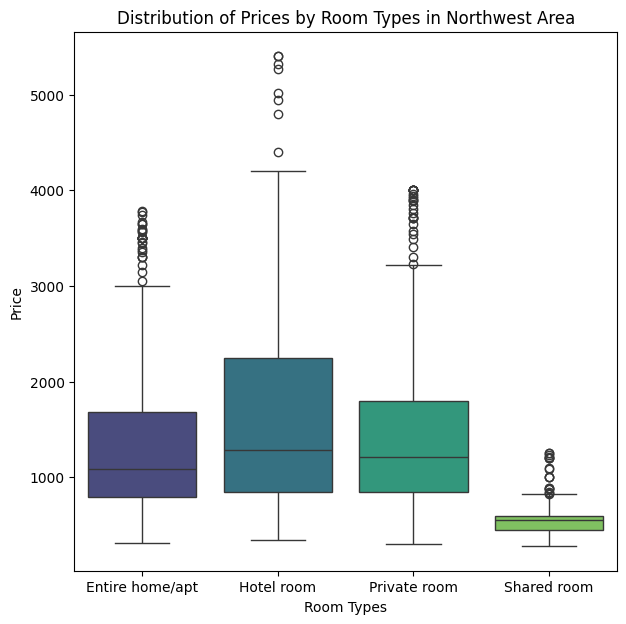

In [490]:
# clean boxplot to see distribution of room_type price side by side
plt.figure(figsize=(7, 7))
sns.boxplot(x = "room_type", y = "price", hue = "room_type", data = northwest_df_cleaned, palette="viridis")
plt.title("Distribution of Prices by Room Types in Northwest Area")
plt.xlabel("Room Types")
plt.ylabel("Price")

# Northeast

In [491]:
# len(northeast_df)

In [492]:
# northeast_df.head()

In [493]:
# northeast_df["neighbourhood"].value_counts()

In [494]:
# northeast_df["room_type"].value_counts()

In [495]:
# room_type price mean
# northeast_df.groupby("room_type")["price"].mean()

In [496]:
# # mean price of room_types in northeast
# plt.figure(figsize=(7, 7))
# sns.barplot(x = "room_type", y = "price", hue = "room_type", data = northeast_df, estimator=np.mean, errorbar= None, palette="viridis")
# plt.title("Mean Price of Room Types in Northeast Area")
# plt.xlabel("Room Types")
# plt.ylabel("Price Mean")

In [497]:
# room_type price median
# northeast_df.groupby("room_type")["price"].median()

In [498]:
# # median price of room_types in northeast
# plt.figure(figsize=(7, 7))
# sns.barplot(x = "room_type", y = "price", hue = "room_type", data = northeast_df, estimator=np.median, errorbar= None, palette="viridis")
# plt.title("Mean Price of Room Types in Northeast Area")
# plt.xlabel("Room Types")
# plt.ylabel("Price Mean")

In [499]:
# # create boxplot to see distribution of room_type price side by side
# plt.figure(figsize=(7, 7))
# sns.boxplot(x = "room_type", y = "price", hue = "room_type", data = northeast_df, palette="viridis")
# plt.title("Distribution of Prices by Room Types in Northeast Area")
# plt.xlabel("Room Types")
# plt.ylabel("Price")

not normally distributed
<br>
need to take care of outliers

In [500]:
# create dataframes based on room_type
ne_eha = northeast_df[northeast_df["room_type"] == "Entire home/apt"]
ne_hr = northeast_df[northeast_df["room_type"] == "Hotel room"]
ne_pr = northeast_df[northeast_df["room_type"] == "Private room"]
ne_sr = northeast_df[northeast_df["room_type"] == "Shared room"]

### entire home/apt

In [501]:
# len(ne_eha)

In [502]:
# ne_eha.head()

In [503]:
# ne_eha.sort_values(by = "price", ascending = False).head(20)

In [504]:
# # raw data distribution
# plt.figure(figsize=(10, 7))
# sns.histplot(data = ne_eha, x="price", color = "#006884")
# plt.title("Distribution of Entire Home/Apt Prices in Northeast Area")
# plt.xlabel("Price")
# plt.ylabel("Count")
# plt.show()

remove extreme outliers

In [505]:
ne_eha = ne_eha[ne_eha["price"] < 60000]

In [506]:
# plt.figure(figsize=(10, 7))
# sns.histplot(data = ne_eha, x="price", color = "#006884")
# plt.title("Distribution of Entire Home/Apt Prices in Northeast Area")
# plt.xlabel("Price")
# plt.ylabel("Count")
# plt.show()

In [507]:
# len(price_outlier(ne_eha)[0])
# len(price_outlier(ne_eha)[1])

remove outliers based on iqr

In [508]:
ne_eha_cleaned = ne_eha[ne_eha["price"] < price_outlier(ne_eha)[-1]]

In [509]:
# # cleaned data distribution
# plt.figure(figsize=(10, 7))
# sns.histplot(data = ne_eha_cleaned, x="price", color = "#006884")
# plt.title("Distribution of Entire Home/Apt Prices in Northeast Area")
# plt.xlabel("Price")
# plt.ylabel("Count")
# plt.show()

### hotel room

In [510]:
# len(ne_hr)

In [511]:
# ne_hr.head()

In [512]:
# ne_hr.sort_values(by = "price", ascending = False).head()

In [513]:
# # raw data distribution
# plt.figure(figsize=(10, 7))
# sns.histplot(data = ne_hr, x="price", color = "#006884")
# plt.title("Distribution of Hotel Room Prices in Northeast Area")
# plt.xlabel("Price")
# plt.ylabel("Count")
# plt.show()

In [514]:
ne_hr = ne_hr[ne_hr["price"] < 17500]

In [515]:
# plt.figure(figsize=(10, 7))
# sns.histplot(data = ne_hr, x="price", color = "#006884")
# plt.title("Distribution of Hotel Room Prices in Northeast Area")
# plt.xlabel("Price")
# plt.ylabel("Count")
# plt.show()

In [516]:
# len(price_outlier(ne_hr)[0])
# len(price_outlier(ne_hr)[1])

remove outliers based on iqr

In [517]:
ne_hr_cleaned = ne_hr[ne_hr["price"] < price_outlier(ne_hr)[-1]]

In [518]:
# # cleaned distribution
# plt.figure(figsize=(10, 7))
# sns.histplot(data = ne_hr_cleaned, x="price", color = "#006884")
# plt.title("Distribution of Hotel Room Prices in Northeast Area")
# plt.xlabel("Price")
# plt.ylabel("Count")
# plt.show()

### private room

In [519]:
# len(ne_pr)

In [520]:
# ne_pr.head()

In [521]:
# ne_pr.sort_values(by = "price", ascending = False).head(20)

In [522]:
# # raw data distribution
# plt.figure(figsize=(10, 7))
# sns.histplot(data = ne_pr, x="price", color = "#006884")
# plt.title("Distribution of Private Room Prices in Northeast Area")
# plt.xlabel("Price")
# plt.ylabel("Count")
# plt.show()

remove extreme outliers

In [523]:
ne_pr = ne_pr[ne_pr["price"] < 100000]

In [524]:
# plt.figure(figsize=(10, 7))
# sns.histplot(data = ne_pr, x="price", color = "#006884")
# plt.title("Distribution of Private Room Prices in Northeast Area")
# plt.xlabel("Price")
# plt.ylabel("Count")
# plt.show()

In [525]:
# len(price_outlier(ne_pr)[0])
# len(price_outlier(ne_pr)[1])

remove outliers based on iqr

In [526]:
ne_pr_cleaned = ne_pr[ne_pr["price"] < price_outlier(ne_pr)[-1]]

In [527]:
# # cleaned distribution
# plt.figure(figsize=(10, 7))
# sns.histplot(data = ne_pr_cleaned, x="price", color = "#006884")
# plt.title("Distribution of Private Room Prices in Northeast Area")
# plt.xlabel("Price")
# plt.ylabel("Count")
# plt.show()

### shared room

In [528]:
# len(ne_sr)

In [529]:
# ne_sr.head()

In [530]:
# ne_sr.sort_values(by = "price", ascending = False).head()

In [531]:
# # raw data distribution
# plt.figure(figsize=(10, 7))
# sns.histplot(data = ne_sr, x="price", color = "#006884")
# plt.title("Distribution of Shared Room Prices in Northeast Area")
# plt.xlabel("Price")
# plt.ylabel("Count")
# plt.show()

remove extreme outlier

In [532]:
ne_sr = ne_sr[ne_sr["price"] < 10000]

In [533]:
# plt.figure(figsize=(10, 7))
# sns.histplot(data = ne_sr, x="price", color = "#006884")
# plt.title("Distribution of Shared Room Prices in Northeast Area")
# plt.xlabel("Price")
# plt.ylabel("Count")
# plt.show()

In [534]:
# len(price_outlier(ne_sr)[0])
# len(price_outlier(ne_sr)[1])

remove outliers based on iqr

In [535]:
ne_sr_cleaned = ne_sr[ne_sr["price"] < price_outlier(ne_sr)[-1]]

In [536]:
# # cleaned distribution
# plt.figure(figsize=(10, 7))
# sns.histplot(data = ne_sr_cleaned, x="price", color = "#006884")
# plt.title("Distribution of Shared Room Prices in Northeast Area")
# plt.xlabel("Price")
# plt.ylabel("Count")
# plt.show()

#### combine all cleaned room_type dataframes for northeast

In [537]:
northeast_df_cleaned = pd.concat([ne_eha_cleaned, ne_hr_cleaned, ne_pr_cleaned, ne_sr_cleaned])

In [538]:
# len(northeast_df_cleaned)

In [539]:
# double check if concat worked properly
# len(ne_eha_cleaned) + len(ne_hr_cleaned) + len(ne_pr_cleaned) + len(ne_sr_cleaned)

Text(0, 0.5, 'Price')

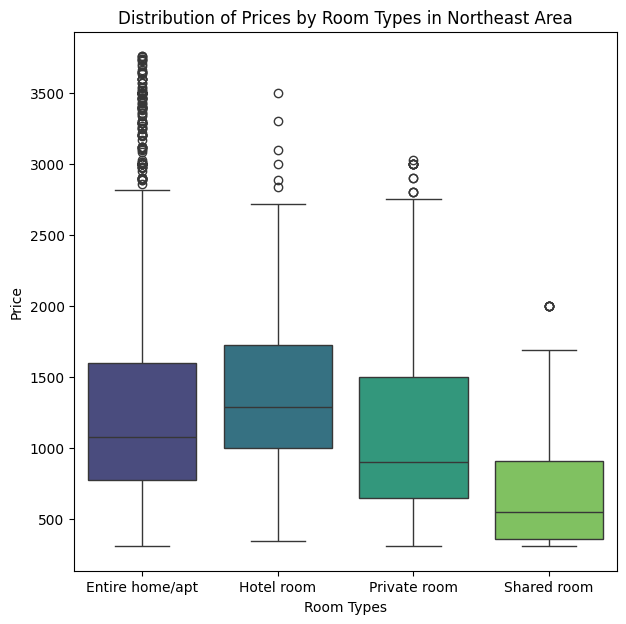

In [540]:
# clean boxplot to see distribution of room_type price side by side
plt.figure(figsize=(7, 7))
sns.boxplot(x = "room_type", y = "price", hue = "room_type", data = northeast_df_cleaned, palette="viridis")
plt.title("Distribution of Prices by Room Types in Northeast Area")
plt.xlabel("Room Types")
plt.ylabel("Price")

# Southwest

In [541]:
# len(southwest_df)

In [542]:
# southwest_df.head()

In [543]:
# southwest_df["neighbourhood"].value_counts()

In [544]:
# southwest_df["room_type"].value_counts()

In [545]:
# room_type price mean
# southwest_df.groupby("room_type")["price"].mean()

In [546]:
# # mean price of room_types in southwest
# plt.figure(figsize=(7, 7))
# sns.barplot(x = "room_type", y = "price", hue = "room_type", data = southwest_df, estimator=np.mean, errorbar= None, palette="viridis")
# plt.title("Mean Price of Room Types in Southwest Area")
# plt.xlabel("Room Types")
# plt.ylabel("Price Mean")


In [547]:
# room_type price median
# southwest_df.groupby("room_type")["price"].median()

In [548]:
# # median price of room_types in southwest
# plt.figure(figsize=(7, 7))
# sns.barplot(x = "room_type", y = "price", hue = "room_type", data = southwest_df, estimator=np.median, errorbar= None, palette="viridis")
# plt.title("Mean Price of Room Types in Southwest Area")
# plt.xlabel("Room Types")
# plt.ylabel("Price Mean")

In [549]:
# # create boxplot to see distribution of room_type price side by side
# plt.figure(figsize=(7, 7))
# sns.boxplot(x = "room_type", y = "price", hue = "room_type", data = southwest_df, palette="viridis")
# plt.title("Distribution of Prices by Room Types in Southwest Area")
# plt.xlabel("Room Types")
# plt.ylabel("Price")

not normally distributed
<br>
outliers need to be handled by room_types

In [550]:
# create dataframes based on room_type
sw_eha = southwest_df[southwest_df["room_type"] == "Entire home/apt"]
sw_hr = southwest_df[southwest_df["room_type"] == "Hotel room"]
sw_pr = southwest_df[southwest_df["room_type"] == "Private room"]
sw_sr = southwest_df[southwest_df["room_type"] == "Shared room"]

### entire home/apt

In [551]:
# len(sw_eha)

In [552]:
# sw_eha.head()

In [553]:
# sw_eha.sort_values(by = "price", ascending = False).head(10)

In [554]:
# # raw data distribution
# plt.figure(figsize=(10, 7))
# sns.histplot(data = sw_eha, x="price", color = "#006884")
# plt.title("Distribution of Entire Home/Apt Prices in Southwest Area")
# plt.xlabel("Price")
# plt.ylabel("Count")
# plt.show()

remove extreme outliers

In [555]:
sw_eha = sw_eha[sw_eha["price"] < 100000]

In [556]:
# plt.figure(figsize=(10, 7))
# sns.histplot(data = sw_eha, x="price", color = "#006884")
# plt.title("Distribution of Entire Home/Apt Prices in Southwest Area")
# plt.xlabel("Price")
# plt.ylabel("Count")
# plt.show()

In [557]:
len(price_outlier(sw_eha)[0])
len(price_outlier(sw_eha)[1])

150

remove outliers based on iqr

In [558]:
sw_eha_cleaned = sw_eha[sw_eha["price"] < price_outlier(sw_eha)[-1]]

In [559]:
# # cleaned distribution
# plt.figure(figsize=(10, 7))
# sns.histplot(data = sw_eha_cleaned, x="price", color = "#006884")
# plt.title("Distribution of Entire Home/Apt Prices in Southwest Area")
# plt.xlabel("Price")
# plt.ylabel("Count")
# plt.show()

### hotel room

In [560]:
# len(sw_hr)

In [561]:
# sw_hr.head()

In [562]:
# sw_hr.sort_values(by = "price", ascending = False).head(10)

In [563]:
# # raw data distribution
# plt.figure(figsize=(10, 7))
# sns.histplot(data = sw_hr, x="price", color = "#006884")
# plt.title("Distribution of Hotel Room Prices in Southwest Area")
# plt.xlabel("Price")
# plt.ylabel("Count")
# plt.show()

In [564]:
# len(price_outlier(sw_hr)[0])
# len(price_outlier(sw_hr)[1])

remove outliers based on iqr

In [565]:
sw_hr_cleaned = sw_hr[sw_hr["price"] < price_outlier(sw_hr)[-1]]

In [566]:
# # cleaned data distribution
# plt.figure(figsize=(10, 7))
# sns.histplot(data = sw_hr_cleaned, x="price", color = "#006884")
# plt.title("Distribution of Hotel Room Prices in Southwest Area")
# plt.xlabel("Price")
# plt.ylabel("Count")
# plt.show()

### private room

In [567]:
# len(sw_pr)

In [568]:
# sw_pr.head()

In [569]:
# sw_pr.sort_values(by = "price", ascending = False).head()

In [570]:
# # raw data distribution
# plt.figure(figsize=(10, 7))
# sns.histplot(data = sw_pr, x="price", color = "#006884")
# plt.title("Distribution of Private Room Prices in Southwest Area")
# plt.xlabel("Price")
# plt.ylabel("Count")
# plt.show()

remove extreme outliers

In [571]:
sw_pr = sw_pr[sw_pr["price"] < 40000]

In [572]:
# plt.figure(figsize=(10, 7))
# sns.histplot(data = sw_pr, x="price", color = "#006884")
# plt.title("Distribution of Private Room Prices in Southwest Area")
# plt.xlabel("Price")
# plt.ylabel("Count")
# plt.show()

In [573]:
len(price_outlier(sw_pr)[0])
len(price_outlier(sw_pr)[1])

65

remove outliers based on iqr

In [574]:
sw_pr_cleaned = sw_pr[sw_pr["price"] < price_outlier(sw_pr)[-1]]

In [575]:
# # cleaned distribution
# plt.figure(figsize=(10, 7))
# sns.histplot(data = sw_pr_cleaned, x="price", color = "#006884")
# plt.title("Distribution of Private Room Prices in Southwest Area")
# plt.xlabel("Price")
# plt.ylabel("Count")
# plt.show()

### shared room

In [576]:
# len(sw_sr)

In [577]:
# sw_sr.head()

In [578]:
# sw_sr.sort_values(by = "price", ascending = False).head()

In [579]:
# # raw data distribution
# plt.figure(figsize=(10, 7))
# sns.histplot(data = sw_sr, x="price", color = "#006884")
# plt.title("Distribution of Shared Room Prices in Southwest Area")
# plt.xlabel("Price")
# plt.ylabel("Count")
# plt.show()

remove extreme outliers

In [580]:
sw_sr = sw_sr[sw_sr["price"] < 6000]

In [581]:
# plt.figure(figsize=(10, 7))
# sns.histplot(data = sw_sr, x="price", color = "#006884")
# plt.title("Distribution of Shared Room Prices in Southwest Area")
# plt.xlabel("Price")
# plt.ylabel("Count")
# plt.show()

In [582]:
# len(price_outlier(sw_sr)[0])
# len(price_outlier(sw_sr)[1])

remove outliers based on iqr

In [583]:
sw_sr_cleaned = sw_sr[sw_sr["price"] < price_outlier(sw_sr)[-1]]

In [584]:
# # cleaned distribution
# plt.figure(figsize=(10, 7))
# sns.histplot(data = sw_sr_cleaned, x="price", color = "#006884")
# plt.title("Distribution of Shared Room Prices in Southwest Area")
# plt.xlabel("Price")
# plt.ylabel("Count")
# plt.show()

#### combine all cleaned room_type dataframe for southwest

In [585]:
southwest_df_cleaned = pd.concat([sw_eha_cleaned, sw_hr_cleaned, sw_pr_cleaned, sw_sr_cleaned])

In [586]:
# len(southwest_df_cleaned)

In [587]:
# check if concat worked properly
# len(sw_eha_cleaned) + len(sw_hr_cleaned) + len(sw_pr_cleaned) + len(sw_sr_cleaned)

Text(0, 0.5, 'Price')

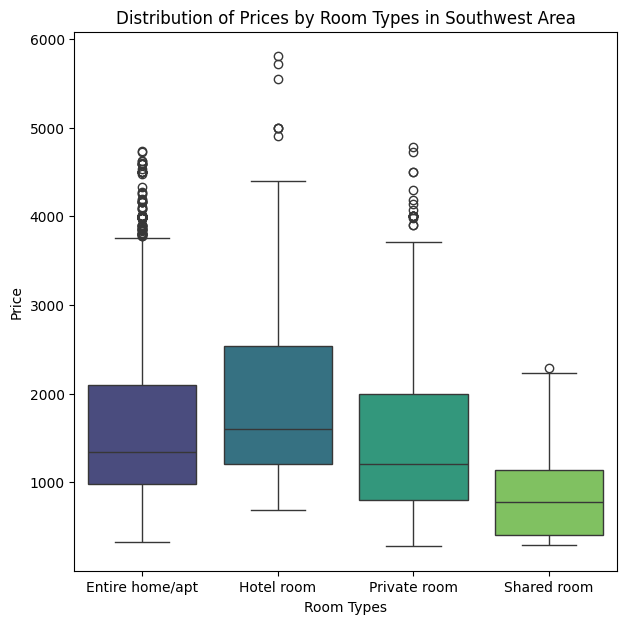

In [588]:
# clean boxplot to see distribution of room_type price side by side
plt.figure(figsize=(7, 7))
sns.boxplot(x = "room_type", y = "price", hue = "room_type", data = southwest_df_cleaned, palette="viridis")
plt.title("Distribution of Prices by Room Types in Southwest Area")
plt.xlabel("Room Types")
plt.ylabel("Price")

# Southeast

In [589]:
# len(southeast_df)

In [590]:
# southeast_df.head()

In [591]:
# southeast_df["neighbourhood"].value_counts()

In [592]:
# southeast_df["room_type"].value_counts()

In [593]:
# room_type price mean
# southeast_df.groupby("room_type")["price"].mean()

In [594]:
# # mean price of room_types in central
# plt.figure(figsize=(7, 7))
# sns.barplot(x = "room_type", y = "price", hue = "room_type", data = southeast_df, estimator=np.mean, errorbar= None, palette="viridis")
# plt.title("Mean Price of Room Types in Southeast Area")
# plt.xlabel("Room Types")
# plt.ylabel("Price Mean")

In [595]:
# room_type price median
# central_df.groupby("room_type")["price"].median()

In [596]:
# # median price of room_types in central
# plt.figure(figsize=(7, 7))
# sns.barplot(x = "room_type", y = "price", hue = "room_type", data = southeast_df, estimator=np.median, errorbar= None, palette="viridis")
# plt.title("Mean Price of Room Types in Southeast Area")
# plt.xlabel("Room Types")
# plt.ylabel("Price Mean")


In [597]:
# # create boxplot to see distribution of room_type price side by side
# plt.figure(figsize=(7, 7))
# sns.boxplot(x = "room_type", y = "price", hue = "room_type", data = southeast_df, palette="viridis")
# plt.title("Distribution of Prices by Room Types in Southeast Area")
# plt.xlabel("Room Types")
# plt.ylabel("Price")

not normally distributed
<br>
handle outliers per room_type

In [598]:
# create dataframes based on room_type
se_eha = southeast_df[southeast_df["room_type"] == "Entire home/apt"]
se_hr = southeast_df[southeast_df["room_type"] == "Hotel room"]
se_pr = southeast_df[southeast_df["room_type"] == "Private room"]
se_sr = southeast_df[southeast_df["room_type"] == "Shared room"]

### entire home/apt

In [599]:
# len(se_eha)

In [600]:
# se_eha.head()

In [601]:
# se_eha.sort_values(by = "price", ascending = False).head()

In [602]:
# # raw data distribution
# plt.figure(figsize=(10, 7))
# sns.histplot(data = se_eha, x="price", color = "#006884")
# plt.title("Distribution of Entire Home/Apt Prices in Southeast Area")
# plt.xlabel("Price")
# plt.ylabel("Count")
# plt.show()

remove extreme outliers

In [603]:
se_eha = se_eha[se_eha["price"] < 20000]

In [604]:
# plt.figure(figsize=(10, 7))
# sns.histplot(data = se_eha, x="price", color = "#006884")
# plt.title("Distribution of Entire Home/Apt Prices in Southeast Area")
# plt.xlabel("Price")
# plt.ylabel("Count")
# plt.show()

In [605]:
# len(price_outlier(se_eha)[0])
# len(price_outlier(se_eha)[1])

remove outliers based on iqr

In [606]:
se_eha_cleaned = se_eha[se_eha["price"] < price_outlier(se_eha)[-1]]

In [607]:
# # cleaned distribution
# plt.figure(figsize=(10, 7))
# sns.histplot(data = se_eha_cleaned, x="price", color = "#006884")
# plt.title("Distribution of Entire Home/Apt Prices in Southeast Area")
# plt.xlabel("Price")
# plt.ylabel("Count")
# plt.show()

### hotel room

In [608]:
# len(se_hr)

In [609]:
# se_hr.head()

In [610]:
# se_hr.sort_values(by = "price", ascending = False).head()

In [611]:
# # raw data distribution
# plt.figure(figsize=(10, 7))
# sns.histplot(data = se_hr, x="price", color = "#006884")
# plt.title("Distribution of Hotel Room Prices in Southeast Area")
# plt.xlabel("Price")
# plt.ylabel("Count")
# plt.show()

In [612]:
# len(price_outlier(se_hr)[0])
# len(price_outlier(se_hr)[1])

remove outliers based on iqr

In [613]:
se_hr_cleaned = se_hr[se_hr["price"] < price_outlier(se_hr)[-1]]

In [614]:
# # cleaned data distribution
# plt.figure(figsize=(10, 7))
# sns.histplot(data = se_hr_cleaned, x="price", color = "#006884")
# plt.title("Distribution of Hotel Room Prices in Southeast Area")
# plt.xlabel("Price")
# plt.ylabel("Count")
# plt.show()

### private room

In [615]:
# len(se_pr)

In [616]:
# se_pr.head()

In [617]:
# se_pr.sort_values(by = "price", ascending = False).head()

In [618]:
# # raw data distribution
# plt.figure(figsize=(10, 7))
# sns.histplot(data = se_pr, x="price", color = "#006884")
# plt.title("Distribution of Private Room Prices in Southeast Area")
# plt.xlabel("Price")
# plt.ylabel("Count")
# plt.show()

remove extreme outliers

In [619]:
se_pr = se_pr[se_pr["price"] < 90000]

In [620]:
# plt.figure(figsize=(10, 7))
# sns.histplot(data = se_pr, x="price", color = "#006884")
# plt.title("Distribution of Private Room Prices in Southeast Area")
# plt.xlabel("Price")
# plt.ylabel("Count")
# plt.show()

In [621]:
# len(price_outlier(se_pr)[0])
# len(price_outlier(se_pr)[1])

remove outliers based on iqr

In [622]:
se_pr_cleaned = se_pr[se_pr["price"] < price_outlier(se_pr)[-1]]

In [623]:
# # cleaned distribution
# plt.figure(figsize=(10, 7))
# sns.histplot(data = se_pr_cleaned, x="price", color = "#006884")
# plt.title("Distribution of Private Room Prices in Southeast Area")
# plt.xlabel("Price")
# plt.ylabel("Count")
# plt.show()

### shared room

In [624]:
# len(se_sr)

In [625]:
# se_sr.head()

In [626]:
# se_hr.sort_values(by = "price", ascending = False).head()

In [627]:
# # raw data distribution
# plt.figure(figsize=(10, 7))
# sns.histplot(data = se_sr, x="price", color = "#006884")
# plt.title("Distribution of Shared Room Prices in Southeast Area")
# plt.xlabel("Price")
# plt.ylabel("Count")
# plt.show()

remove extreme outlier

In [628]:
se_sr = se_sr[se_sr["price"] < 4000]

In [629]:
# plt.figure(figsize=(10, 7))
# sns.histplot(data = se_sr, x="price", color = "#006884")
# plt.title("Distribution of Shared Room Prices in Southeast Area")
# plt.xlabel("Price")
# plt.ylabel("Count")
# plt.show()

In [630]:
# len(price_outlier(se_sr)[0])
# len(price_outlier(se_sr)[1])

remove outliers based on iqr

In [631]:
se_sr_cleaned = se_sr[se_sr["price"] < price_outlier(se_sr)[-1]]

In [632]:
# # cleaned distribution
# plt.figure(figsize=(10, 7))
# sns.histplot(data = se_sr_cleaned, x="price", color = "#006884")
# plt.title("Distribution of Shared Room Prices in Southeast Area")
# plt.xlabel("Price")
# plt.ylabel("Count")
# plt.show()

#### combine all cleaned room_type dataframes for southeast

In [633]:
southeast_df_cleaned = pd.concat([se_eha_cleaned, se_hr_cleaned, se_pr_cleaned, se_sr_cleaned])

In [634]:
# len(southeast_df_cleaned)

In [635]:
# double check if concat worked properly
# len(se_eha_cleaned) + len(se_hr_cleaned) + len(se_pr_cleaned) + len(se_sr_cleaned)

Text(0, 0.5, 'Price')

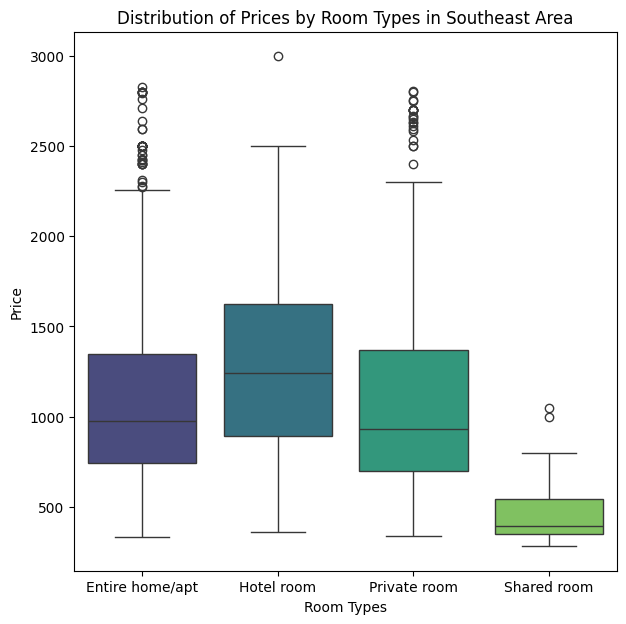

In [636]:
# clean boxplot to see distribution of room_type price side by side
plt.figure(figsize=(7, 7))
sns.boxplot(x = "room_type", y = "price", hue = "room_type", data = southeast_df_cleaned, palette="viridis")
plt.title("Distribution of Prices by Room Types in Southeast Area")
plt.xlabel("Room Types")
plt.ylabel("Price")

#### combine all regional dataframes into one clean df

In [637]:
df = pd.concat([central_df_cleaned, northwest_df_cleaned, northeast_df_cleaned, southwest_df_cleaned, southeast_df_cleaned]).reset_index(drop = True)

In [638]:
eha_df = df[df["room_type"] == "Entire home/apt"]
hr_df = df[df["room_type"] == "Hotel room"]
pr_df = df[df["room_type"] == "Private room"]
sr_df = df[df["room_type"] == "Shared room"]

# Cleaning Reviews Column

since i want to see which region is the best for investment for each room type, i will group by room type first and apply the same review categories across all regions

In [639]:
# # histplot of numner_of_reviews in all regions for all room types
# plt.figure(figsize=(20, 10))
# plt.title("Count of Number of Reviews for Each Room Type by Region\n")

# plt.subplot(2, 2, 1)
# sns.histplot(x = "number_of_reviews", data = eha_df, hue = "region", palette="viridis")
# plt.title("Entire Home/Apt")

# plt.subplot(2, 2, 2)
# sns.histplot(x = "number_of_reviews", data = hr_df, hue = "region", palette="viridis")
# plt.title("Hotel Room")

# plt.subplot(2, 2, 3)
# sns.histplot(x = "number_of_reviews", data = pr_df, hue = "region", palette="viridis")
# plt.title("Private Room")

# plt.subplot(2, 2, 4)
# sns.histplot(x = "number_of_reviews", data = sr_df, hue = "region", palette="viridis")
# plt.title("Shared Room")

In [640]:
# # reviews are too skewed to the right - logging
# eha_df.loc[:, "log_reviews_count"] = np.log1p(eha_df["number_of_reviews"].values)
# hr_df.loc[:,"log_reviews_count"] = np.log1p(hr_df["number_of_reviews"].values)
# pr_df.loc[:,"log_reviews_count"] = np.log1p(pr_df["number_of_reviews"].values)
# sr_df.loc[:,"log_reviews_count"] = np.log1p(sr_df["number_of_reviews"].values)

In [641]:
# # histplot of after logging
# plt.figure(figsize=(20, 10))
# plt.title("Logged Number of Reviews for Each Room Type by Region\n")

# plt.subplot(2, 2, 1)
# sns.histplot(x = "log_reviews_count", data = eha_df, hue = "region", palette="viridis")
# plt.title("Entire Home/Apt")

# plt.subplot(2, 2, 2)
# sns.histplot(x = "log_reviews_count", data = hr_df, hue = "region", palette="viridis")
# plt.title("Hotel Room")

# plt.subplot(2, 2, 3)
# sns.histplot(x = "log_reviews_count", data = pr_df, hue = "region", palette="viridis")
# plt.title("Private Room")

# plt.subplot(2, 2, 4)
# sns.histplot(x = "log_reviews_count", data = sr_df, hue = "region", palette="viridis")
# plt.title("Shared Room")

In [642]:
# # define new column for number_of_reviews ordinal - reviews_activity came from number_of_reviews
# def ordinal_reviews_count(df):
#     q1 = df["log_reviews_count"].quantile(0.33)
#     q2 = df["log_reviews_count"].quantile(0.66)

#     bins = [df["log_reviews_count"].min(), q1 + 0.01, q2, df["log_reviews_count"].max()]
#     labels = ["Low", "Moderate", "High"]
#     df.loc[:, "reviews_activity"] = pd.cut(df["log_reviews_count"], bins=bins, labels=labels, include_lowest=True)

#     return df

In [643]:
# eha_df = ordinal_reviews_count(eha_df)
# hr_df = ordinal_reviews_count(hr_df)
# pr_df = ordinal_reviews_count(pr_df)
# sr_df = ordinal_reviews_count(sr_df)

In [644]:
# # histplot of reviews_per_month in all regions for all room types
# plt.figure(figsize=(20, 10))
# plt.title("Count of Reviews per Month for Each Room Type by Region\n")

# plt.subplot(2, 2, 1)
# sns.histplot(x = "reviews_per_month", data = eha_df, hue = "region", palette="viridis")
# plt.title("Entire Home/Apt")

# plt.subplot(2, 2, 2)
# sns.histplot(x = "reviews_per_month", data = hr_df, hue = "region", palette="viridis")
# plt.title("Hotel Room")

# plt.subplot(2, 2, 3)
# sns.histplot(x = "reviews_per_month", data = pr_df, hue = "region", palette="viridis")
# plt.title("Private Room")

# plt.subplot(2, 2, 4)
# sns.histplot(x = "reviews_per_month", data = sr_df, hue = "region", palette="viridis")
# plt.title("Shared Room")

In [645]:
# # reviews are too skewed to the right - logging
# eha_df.loc[:, "log_reviews_month"] = np.log1p(eha_df["reviews_per_month"])
# hr_df.loc[:, "log_reviews_month"] = np.log1p(hr_df["reviews_per_month"])
# pr_df.loc[:, "log_reviews_month"] = np.log1p(pr_df["reviews_per_month"])
# sr_df.loc[:, "log_reviews_month"] = np.log1p(sr_df["reviews_per_month"])

In [646]:
# # histplot of after logging
# plt.figure(figsize=(20, 10))
# plt.title("Logged Reviews per Month for Each Room Type by Region\n")

# plt.subplot(2, 2, 1)
# sns.histplot(x = "log_reviews_month", data = eha_df, hue = "region", palette="viridis")
# plt.title("Entire Home/Apt")

# plt.subplot(2, 2, 2)
# sns.histplot(x = "log_reviews_month", data = hr_df, hue = "region", palette="viridis")
# plt.title("Hotel Room")

# plt.subplot(2, 2, 3)
# sns.histplot(x = "log_reviews_month", data = pr_df, hue = "region", palette="viridis")
# plt.title("Private Room")

# plt.subplot(2, 2, 4)
# sns.histplot(x = "log_reviews_month", data = sr_df, hue = "region", palette="viridis")
# plt.title("Shared Room")

In [647]:
# # reviews are too still skewed to the right - squaring
# eha_df.loc[:, "sqrt_reviews_month"] = np.sqrt(eha_df["reviews_per_month"])
# hr_df.loc[:, "sqrt_reviews_month"] = np.sqrt(hr_df["reviews_per_month"])
# pr_df.loc[:, "sqrt_reviews_month"] = np.sqrt(pr_df["reviews_per_month"])
# sr_df.loc[:, "sqrt_reviews_month"] = np.sqrt(sr_df["reviews_per_month"])

In [648]:
# # histplot of after squaring
# plt.figure(figsize=(20, 10))
# plt.title("Squared Reviews per Month for Each Room Type by Region\n")

# plt.subplot(2, 2, 1)
# sns.histplot(x = "sqrt_reviews_month", data = eha_df, hue = "region", palette="viridis")
# plt.title("Entire Home/Apt")

# plt.subplot(2, 2, 2)
# sns.histplot(x = "sqrt_reviews_month", data = hr_df, hue = "region", palette="viridis")
# plt.title("Hotel Room")

# plt.subplot(2, 2, 3)
# sns.histplot(x = "sqrt_reviews_month", data = pr_df, hue = "region", palette="viridis")
# plt.title("Private Room")

# plt.subplot(2, 2, 4)
# sns.histplot(x = "sqrt_reviews_month", data = sr_df, hue = "region", palette="viridis")
# plt.title("Shared Room")

In [649]:
from scipy import stats

In [650]:
# reviews count are too still skewed to the right - box-cox
eha_df.loc[:, "boxcox_reviews_count"], _ = stats.boxcox(eha_df["number_of_reviews"] + 1)
hr_df.loc[:, "boxcox_reviews_count"], _ = stats.boxcox(hr_df["number_of_reviews"] + 1)
pr_df.loc[:, "boxcox_reviews_count"], _ = stats.boxcox(pr_df["number_of_reviews"] + 1)
sr_df.loc[:, "boxcox_reviews_count"], _ = stats.boxcox(sr_df["number_of_reviews"] + 1)

C:\Users\amfed\AppData\Local\Temp\ipykernel_19172\4072897318.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  eha_df.loc[:, "boxcox_reviews_count"], _ = stats.boxcox(eha_df["number_of_reviews"] + 1)
C:\Users\amfed\AppData\Local\Temp\ipykernel_19172\4072897318.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hr_df.loc[:, "boxcox_reviews_count"], _ = stats.boxcox(hr_df["number_of_reviews"] + 1)
C:\Users\amfed\AppData\Local\Temp\ipykernel_19172\4072897318.py:4: SettingWithCopyWarning: 
A value is trying 

In [651]:
# # histplot of after boxcox
# plt.figure(figsize=(20, 10))
# plt.title("Box-Cox Number of Reviews for Each Room Type by Region\n")
# plt.box(on= None)
# plt.axis("off")

# plt.subplot(2, 2, 1)
# sns.histplot(x = "boxcox_reviews_count", data = eha_df, hue = "region", palette="viridis")
# plt.title("Entire Home/Apt")

# plt.subplot(2, 2, 2)
# sns.histplot(x = "boxcox_reviews_count", data = hr_df, hue = "region", palette="viridis")
# plt.title("Hotel Room")

# plt.subplot(2, 2, 3)
# sns.histplot(x = "boxcox_reviews_count", data = pr_df, hue = "region", palette="viridis")
# plt.title("Private Room")

# plt.subplot(2, 2, 4)
# sns.histplot(x = "boxcox_reviews_count", data = sr_df, hue = "region", palette="viridis")
# plt.title("Shared Room")

In [652]:
# reviews per month are too still skewed to the right - box-cox
eha_df.loc[:, "boxcox_reviews_month"], _ = stats.boxcox(eha_df["reviews_per_month"] + 1)
hr_df.loc[:, "boxcox_reviews_month"], _ = stats.boxcox(hr_df["reviews_per_month"] + 1)
pr_df.loc[:, "boxcox_reviews_month"], _ = stats.boxcox(pr_df["reviews_per_month"] + 1)
sr_df.loc[:, "boxcox_reviews_month"], _ = stats.boxcox(sr_df["reviews_per_month"] + 1)

C:\Users\amfed\AppData\Local\Temp\ipykernel_19172\3827868114.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  eha_df.loc[:, "boxcox_reviews_month"], _ = stats.boxcox(eha_df["reviews_per_month"] + 1)
C:\Users\amfed\AppData\Local\Temp\ipykernel_19172\3827868114.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hr_df.loc[:, "boxcox_reviews_month"], _ = stats.boxcox(hr_df["reviews_per_month"] + 1)
C:\Users\amfed\AppData\Local\Temp\ipykernel_19172\3827868114.py:4: SettingWithCopyWarning: 
A value is trying 

In [653]:
# # histplot of after boxcox
# plt.figure(figsize=(20, 10))
# plt.title("Box-Cox Reviews per Month for Each Room Type by Region\n")
# plt.box(on= None)
# plt.axis("off")

# plt.subplot(2, 2, 1)
# sns.histplot(x = "boxcox_reviews_month", data = eha_df, hue = "region", palette="viridis")
# plt.title("Entire Home/Apt")

# plt.subplot(2, 2, 2)
# sns.histplot(x = "boxcox_reviews_month", data = hr_df, hue = "region", palette="viridis")
# plt.title("Hotel Room")

# plt.subplot(2, 2, 3)
# sns.histplot(x = "boxcox_reviews_month", data = pr_df, hue = "region", palette="viridis")
# plt.title("Private Room")

# plt.subplot(2, 2, 4)
# sns.histplot(x = "boxcox_reviews_month", data = sr_df, hue = "region", palette="viridis")
# plt.title("Shared Room")

In [654]:
eha_df.head()

,id,name,host_id,host_name,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,number_of_reviews_ltm,region,boxcox_reviews_count,boxcox_reviews_month
0,27934,Nice room with superb city view,120437,Nuttee,Ratchathewi,13.75983,100.54134,Entire home/apt,1905,3,65,2020-01-06,0.50,2,353,0,Central,2.928458,0.301359
1,959254,"Deluxe Condo, Nana, Pool/GYM/Sauna",5153476,Natcha,Khlong Toei,13.71516,100.56806,Entire home/apt,1400,30,0,No Review,0.00,1,365,0,Central,0.000000,0.000000
2,1791481,Nice and Quiet condo near BTS Onnut,9399478,Piyakorn,Khlong Toei,13.70719,100.59936,Entire home/apt,1577,30,78,2019-05-31,0.78,1,330,0,Central,3.010781,0.381783
3,1793000,The Duplex - Asoke- Luxury 92sqm,9407280,Timo,Vadhana,13.74668,100.56137,Entire home/apt,5034,21,287,2022-11-22,2.59,1,349,3,Central,3.529709,0.557674
4,1808600,Contemporary Modern Duplex-Thong Lo,9478184,Shine,Khlong Toei,13.72097,100.57823,Entire home/apt,2078,60,83,2018-09-12,0.75,1,55,0,Central,3.038267,0.374712


In [655]:
def ordinal_reviews_count(df):
    q1 = df["boxcox_reviews_count"].quantile(0.33)
    q2 = df["boxcox_reviews_count"].quantile(0.66)

    bins = [df["boxcox_reviews_count"].min(), q1 + 0.01, q2, df["boxcox_reviews_count"].max()]
    labels = ["Low", "Moderate", "High"]

    df = df.copy()  # Ensure we're working with a copy to avoid SettingWithCopyWarning
    df.loc[:, "reviews_activity"] = pd.cut(df["boxcox_reviews_count"], bins=bins, labels=labels, include_lowest=True)

    return df  # Return the modified DataFrame


In [656]:
eha_df = ordinal_reviews_count(eha_df)
hr_df = ordinal_reviews_count(hr_df)
pr_df = ordinal_reviews_count(pr_df)
sr_df = ordinal_reviews_count(sr_df)

In [657]:
def ordinal_reviews_month(df):
    q1 = df["boxcox_reviews_month"].quantile(0.33)
    q2 = df["boxcox_reviews_month"].quantile(0.66)

    bins = [df["boxcox_reviews_month"].min(), q1 + 0.01, q2, df["boxcox_reviews_month"].max()]
    labels = ["Low", "Moderate", "High"]

    df = df.copy()  # Ensure we're working with a copy to avoid SettingWithCopyWarning
    df.loc[:, "reviews_engagement"] = pd.cut(df["boxcox_reviews_month"], bins=bins, labels=labels, include_lowest=True)

    return df  # Return the modified DataFrame

In [658]:
eha_df = ordinal_reviews_month(eha_df)
hr_df = ordinal_reviews_month(hr_df)
pr_df = ordinal_reviews_month(pr_df)
sr_df = ordinal_reviews_month(sr_df)

In [659]:
eha_df.head()

,id,name,host_id,host_name,neighbourhood,latitude,longitude,room_type,price,minimum_nights,...,last_review,reviews_per_month,calculated_host_listings_count,availability_365,number_of_reviews_ltm,region,boxcox_reviews_count,boxcox_reviews_month,reviews_activity,reviews_engagement
0,27934,Nice room with superb city view,120437,Nuttee,Ratchathewi,13.75983,100.54134,Entire home/apt,1905,3,...,2020-01-06,0.50,2,353,0,Central,2.928458,0.301359,High,Moderate
1,959254,"Deluxe Condo, Nana, Pool/GYM/Sauna",5153476,Natcha,Khlong Toei,13.71516,100.56806,Entire home/apt,1400,30,...,No Review,0.00,1,365,0,Central,0.000000,0.000000,Low,Low
2,1791481,Nice and Quiet condo near BTS Onnut,9399478,Piyakorn,Khlong Toei,13.70719,100.59936,Entire home/apt,1577,30,...,2019-05-31,0.78,1,330,0,Central,3.010781,0.381783,High,High
3,1793000,The Duplex - Asoke- Luxury 92sqm,9407280,Timo,Vadhana,13.74668,100.56137,Entire home/apt,5034,21,...,2022-11-22,2.59,1,349,3,Central,3.529709,0.557674,High,High
4,1808600,Contemporary Modern Duplex-Thong Lo,9478184,Shine,Khlong Toei,13.72097,100.57823,Entire home/apt,2078,60,...,2018-09-12,0.75,1,55,0,Central,3.038267,0.374712,High,High


In [660]:
df = pd.concat([eha_df, hr_df, pr_df, sr_df])

In [661]:
df.isna().sum()

id                                0
name                              0
host_id                           0
host_name                         0
neighbourhood                     0
latitude                          0
longitude                         0
room_type                         0
price                             0
minimum_nights                    0
number_of_reviews                 0
last_review                       0
reviews_per_month                 0
calculated_host_listings_count    0
availability_365                  0
number_of_reviews_ltm             0
region                            0
boxcox_reviews_count              0
boxcox_reviews_month              0
reviews_activity                  0
reviews_engagement                0
dtype: int64

In [662]:
df2 = df.drop(columns=["name", "host_name", "latitude", "longitude", "number_of_reviews", "last_review", "reviews_per_month", "calculated_host_listings_count", "number_of_reviews_ltm"])

In [663]:
df2 = df2.rename(columns={"boxcox_reviews_count": "reviews_count_bc", "boxcox_reviews_month": "reviews_month_bc"})

In [664]:
df2 = df2[["id", "host_id", "neighbourhood", "region", "room_type", "price", "reviews_activity", "reviews_engagement", "availability_365"]]

In [665]:
df2.head()

,id,host_id,neighbourhood,region,room_type,price,reviews_activity,reviews_engagement,availability_365
0,27934,120437,Ratchathewi,Central,Entire home/apt,1905,High,Moderate,353
1,959254,5153476,Khlong Toei,Central,Entire home/apt,1400,Low,Low,365
2,1791481,9399478,Khlong Toei,Central,Entire home/apt,1577,High,High,330
3,1793000,9407280,Vadhana,Central,Entire home/apt,5034,High,High,349
4,1808600,9478184,Khlong Toei,Central,Entire home/apt,2078,High,High,55


In [666]:
df2.loc[:, "booking_activity"] = 365 - df2["availability_365"]

In [667]:
eha_df2 = df2[df2["room_type"] == "Entire home/apt"]
hr_df2 = df2[df2["room_type"] == "Hotel room"]
pr_df2 = df2[df2["room_type"] == "Private room"]
sr_df2 = df2[df2["room_type"] == "Shared room"]

Text(0.5, 1.0, 'Shared Room')

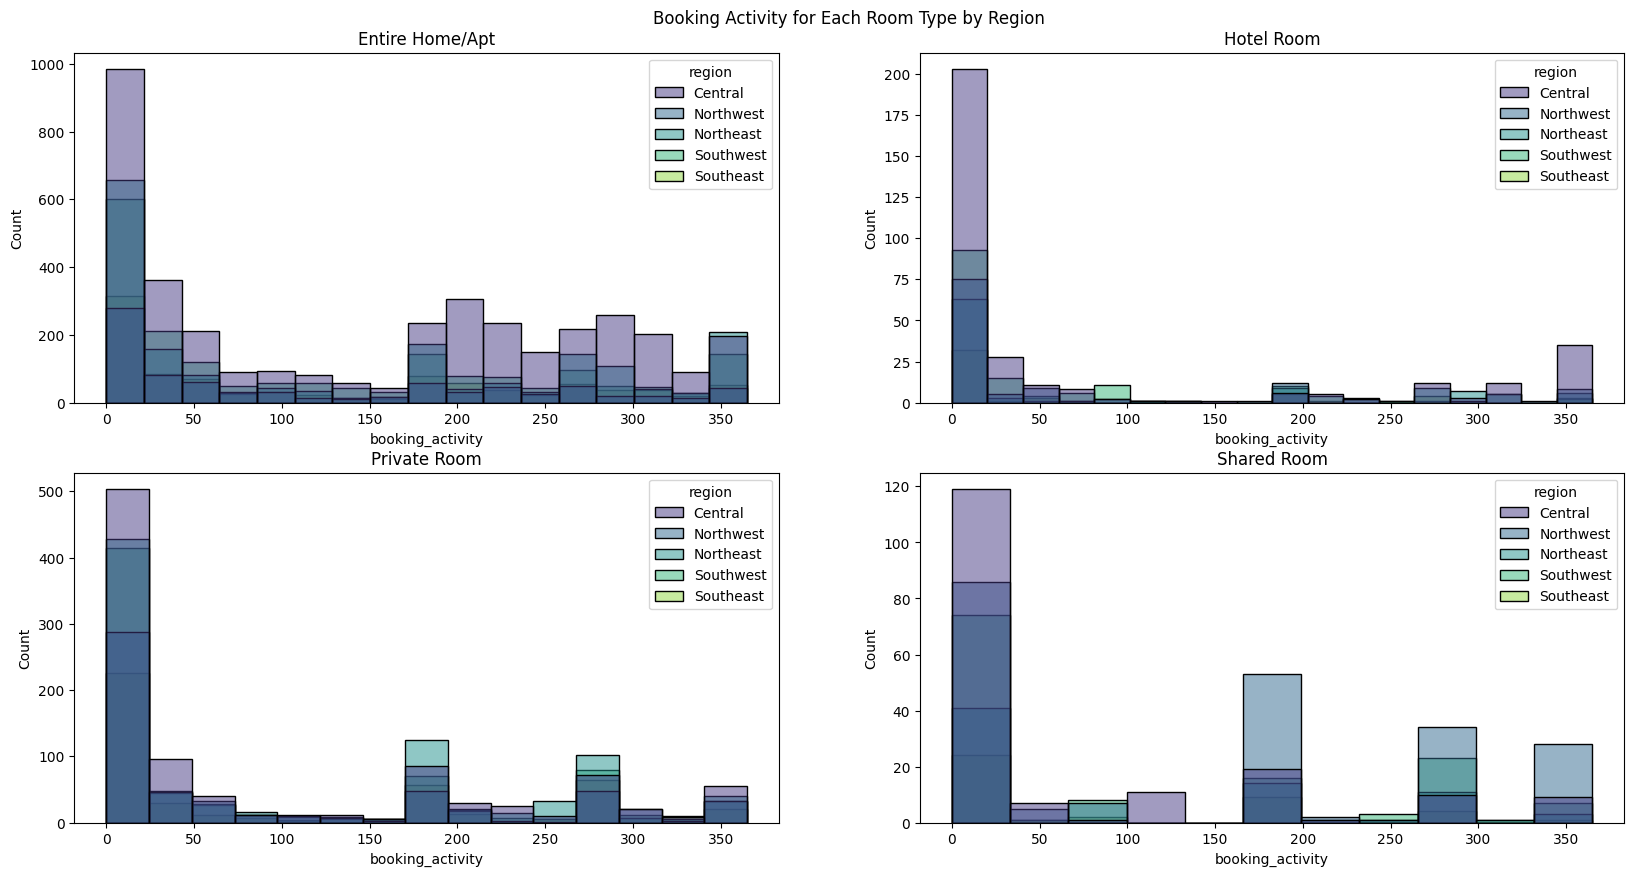

In [668]:
# histplot booking_activity
plt.figure(figsize=(20, 10))
plt.title("Booking Activity for Each Room Type by Region\n")
plt.box(on= None)
plt.axis("off")

plt.subplot(2, 2, 1)
sns.histplot(x = "booking_activity", data = eha_df2, hue = "region", palette="viridis")
plt.title("Entire Home/Apt")

plt.subplot(2, 2, 2)
sns.histplot(x = "booking_activity", data = hr_df2, hue = "region", palette="viridis")
plt.title("Hotel Room")

plt.subplot(2, 2, 3)
sns.histplot(x = "booking_activity", data = pr_df2, hue = "region", palette="viridis")
plt.title("Private Room")

plt.subplot(2, 2, 4)
sns.histplot(x = "booking_activity", data = sr_df2, hue = "region", palette="viridis")
plt.title("Shared Room")

In [669]:
# reviews per month are too still skewed to the right - box-cox
eha_df2.loc[:, "bc_booking"], _ = stats.boxcox(eha_df2["booking_activity"] + 1)
hr_df2.loc[:, "bc_booking"], _ = stats.boxcox(hr_df2["booking_activity"] + 1)
pr_df2.loc[:, "bc_booking"], _ = stats.boxcox(pr_df2["booking_activity"] + 1)
sr_df2.loc[:, "bc_booking"], _ = stats.boxcox(sr_df2["booking_activity"] + 1)

C:\Users\amfed\AppData\Local\Temp\ipykernel_19172\1448651630.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  eha_df2.loc[:, "bc_booking"], _ = stats.boxcox(eha_df2["booking_activity"] + 1)
C:\Users\amfed\AppData\Local\Temp\ipykernel_19172\1448651630.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hr_df2.loc[:, "bc_booking"], _ = stats.boxcox(hr_df2["booking_activity"] + 1)
C:\Users\amfed\AppData\Local\Temp\ipykernel_19172\1448651630.py:4: SettingWithCopyWarning: 
A value is trying to be set on a cop

Text(0.5, 1.0, 'Shared Room')

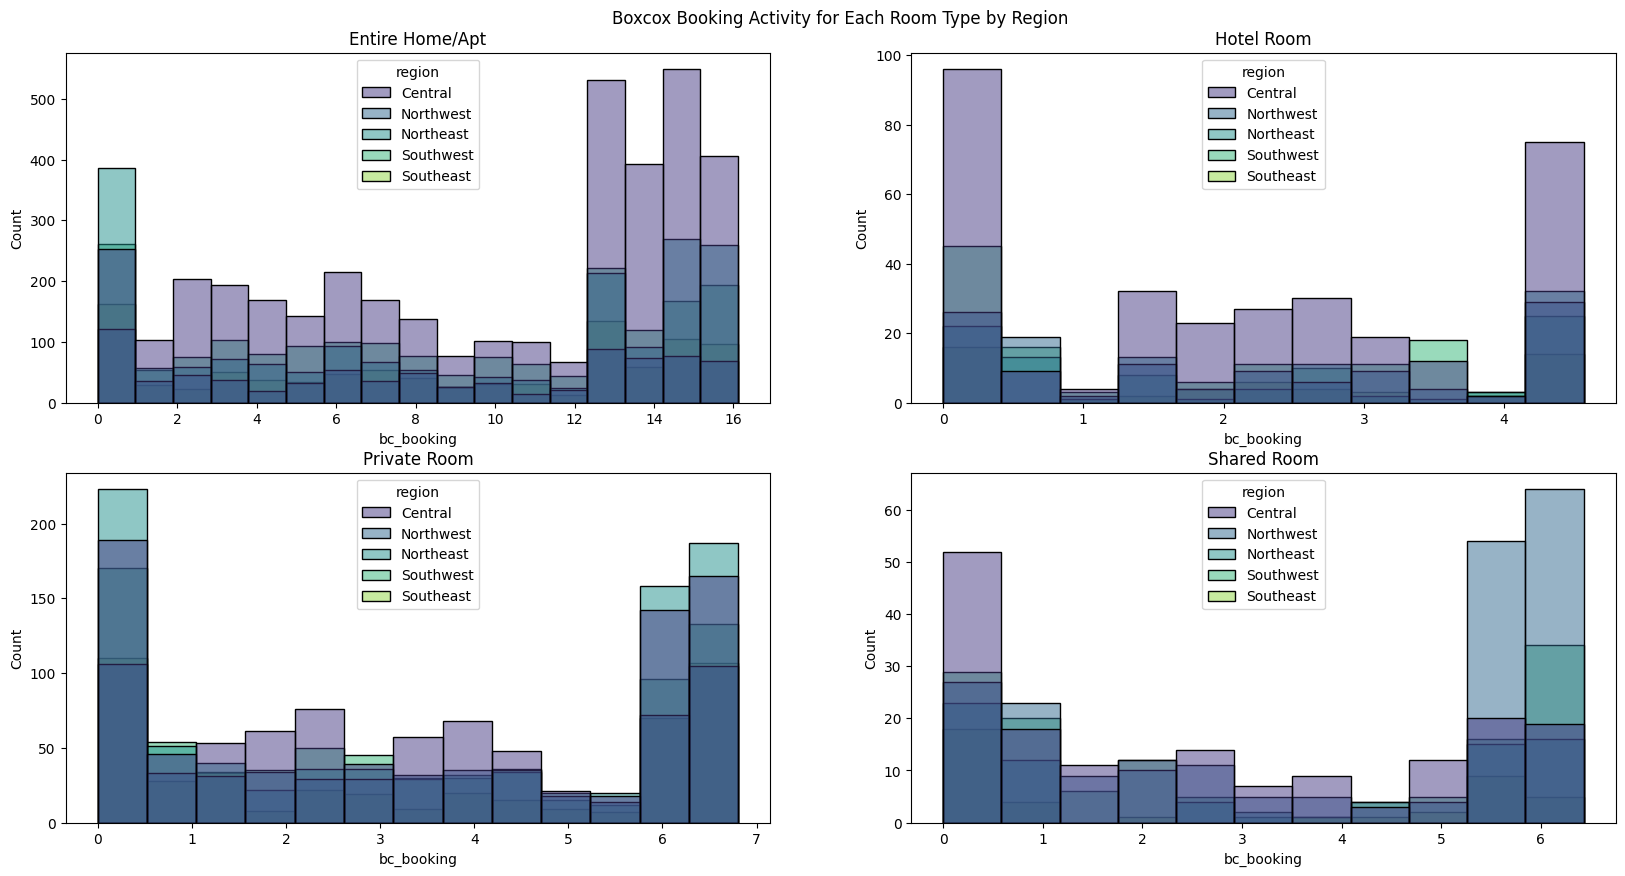

In [670]:
# histplot booking_activity
plt.figure(figsize=(20, 10))
plt.title("Boxcox Booking Activity for Each Room Type by Region\n")
plt.box(on= None)
plt.axis("off")

plt.subplot(2, 2, 1)
sns.histplot(x = "bc_booking", data = eha_df2, hue = "region", palette="viridis")
plt.title("Entire Home/Apt")

plt.subplot(2, 2, 2)
sns.histplot(x = "bc_booking", data = hr_df2, hue = "region", palette="viridis")
plt.title("Hotel Room")

plt.subplot(2, 2, 3)
sns.histplot(x = "bc_booking", data = pr_df2, hue = "region", palette="viridis")
plt.title("Private Room")

plt.subplot(2, 2, 4)
sns.histplot(x = "bc_booking", data = sr_df2, hue = "region", palette="viridis")
plt.title("Shared Room")

In [671]:
def ordinal_booking_activity(df):
    q1 = df["bc_booking"].quantile(0.33)
    q2 = df["bc_booking"].quantile(0.66)

    bins = [df["bc_booking"].min(), q1 + 0.01, q2, df["bc_booking"].max()]
    labels = ["Low", "Moderate", "High"]

    df = df.copy()  # Ensure we're working with a copy to avoid SettingWithCopyWarning
    df.loc[:, "booking_activity_ord"] = pd.cut(df["bc_booking"], bins=bins, labels=labels, include_lowest=True)

    return df  # Return the modified DataFrame

In [672]:
eha_df2 = ordinal_booking_activity(eha_df2)
hr_df2 = ordinal_booking_activity(hr_df2)
pr_df2 = ordinal_booking_activity(pr_df2)
sr_df2 = ordinal_booking_activity(sr_df2)

In [673]:
df3 = pd.concat([eha_df2, hr_df2, pr_df2, sr_df2])

In [674]:
df3.head()

,id,host_id,neighbourhood,region,room_type,price,reviews_activity,reviews_engagement,availability_365,booking_activity,bc_booking,booking_activity_ord
0,27934,120437,Ratchathewi,Central,Entire home/apt,1905,High,Moderate,353,12,3.850076,Low
1,959254,5153476,Khlong Toei,Central,Entire home/apt,1400,Low,Low,365,0,0.000000,Low
2,1791481,9399478,Khlong Toei,Central,Entire home/apt,1577,High,High,330,35,6.404489,Moderate
3,1793000,9407280,Vadhana,Central,Entire home/apt,5034,High,High,349,16,4.449578,Low
4,1808600,9478184,Khlong Toei,Central,Entire home/apt,2078,High,High,55,310,15.196792,High


In [675]:
df3 = df3[["id", "neighbourhood", "region", "room_type", "price", "reviews_activity", "booking_activity_ord"]]

In [676]:
df3.head()

,id,neighbourhood,region,room_type,price,reviews_activity,booking_activity_ord
0,27934,Ratchathewi,Central,Entire home/apt,1905,High,Low
1,959254,Khlong Toei,Central,Entire home/apt,1400,Low,Low
2,1791481,Khlong Toei,Central,Entire home/apt,1577,High,Moderate
3,1793000,Vadhana,Central,Entire home/apt,5034,High,Low
4,1808600,Khlong Toei,Central,Entire home/apt,2078,High,High


In [677]:
df3["reviews_activity_num"] = df3["reviews_activity"].map({"Low": 1, "Moderate": 2, "High": 3})
df3["booking_activity_num"] = df3["booking_activity_ord"].map({"Low": 1, "Moderate": 2, "High": 3})

In [678]:
df3.head()

,id,neighbourhood,region,room_type,price,reviews_activity,booking_activity_ord,reviews_activity_num,booking_activity_num
0,27934,Ratchathewi,Central,Entire home/apt,1905,High,Low,3,1
1,959254,Khlong Toei,Central,Entire home/apt,1400,Low,Low,1,1
2,1791481,Khlong Toei,Central,Entire home/apt,1577,High,Moderate,3,2
3,1793000,Vadhana,Central,Entire home/apt,5034,High,Low,3,1
4,1808600,Khlong Toei,Central,Entire home/apt,2078,High,High,3,3


In [679]:
df3.info()

<class 'pandas.core.frame.DataFrame'>
Index: 14387 entries, 0 to 14386
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   id                    14387 non-null  int64   
 1   neighbourhood         14387 non-null  object  
 2   region                14387 non-null  object  
 3   room_type             14387 non-null  object  
 4   price                 14387 non-null  int64   
 5   reviews_activity      14387 non-null  category
 6   booking_activity_ord  14387 non-null  category
 7   reviews_activity_num  14387 non-null  category
 8   booking_activity_num  14387 non-null  category
dtypes: category(4), int64(2), object(3)
memory usage: 731.1+ KB


In [680]:
df3["reviews_activity_num"] = df3["reviews_activity_num"].astype(int)
df3["booking_activity_num"] = df3["booking_activity_num"].astype(int)

In [681]:
df3["popularity"] = (df3["reviews_activity_num"] + df3["booking_activity_num"]) / 2

In [682]:
df3.head()

,id,neighbourhood,region,room_type,price,reviews_activity,booking_activity_ord,reviews_activity_num,booking_activity_num,popularity
0,27934,Ratchathewi,Central,Entire home/apt,1905,High,Low,3,1,2.0
1,959254,Khlong Toei,Central,Entire home/apt,1400,Low,Low,1,1,1.0
2,1791481,Khlong Toei,Central,Entire home/apt,1577,High,Moderate,3,2,2.5
3,1793000,Vadhana,Central,Entire home/apt,5034,High,Low,3,1,2.0
4,1808600,Khlong Toei,Central,Entire home/apt,2078,High,High,3,3,3.0


In [683]:
# revenue potential = popularity x price
df3["revenue_pot"] = df3["price"] * df3["popularity"]

Text(0.5, 1.0, 'Shared Room')

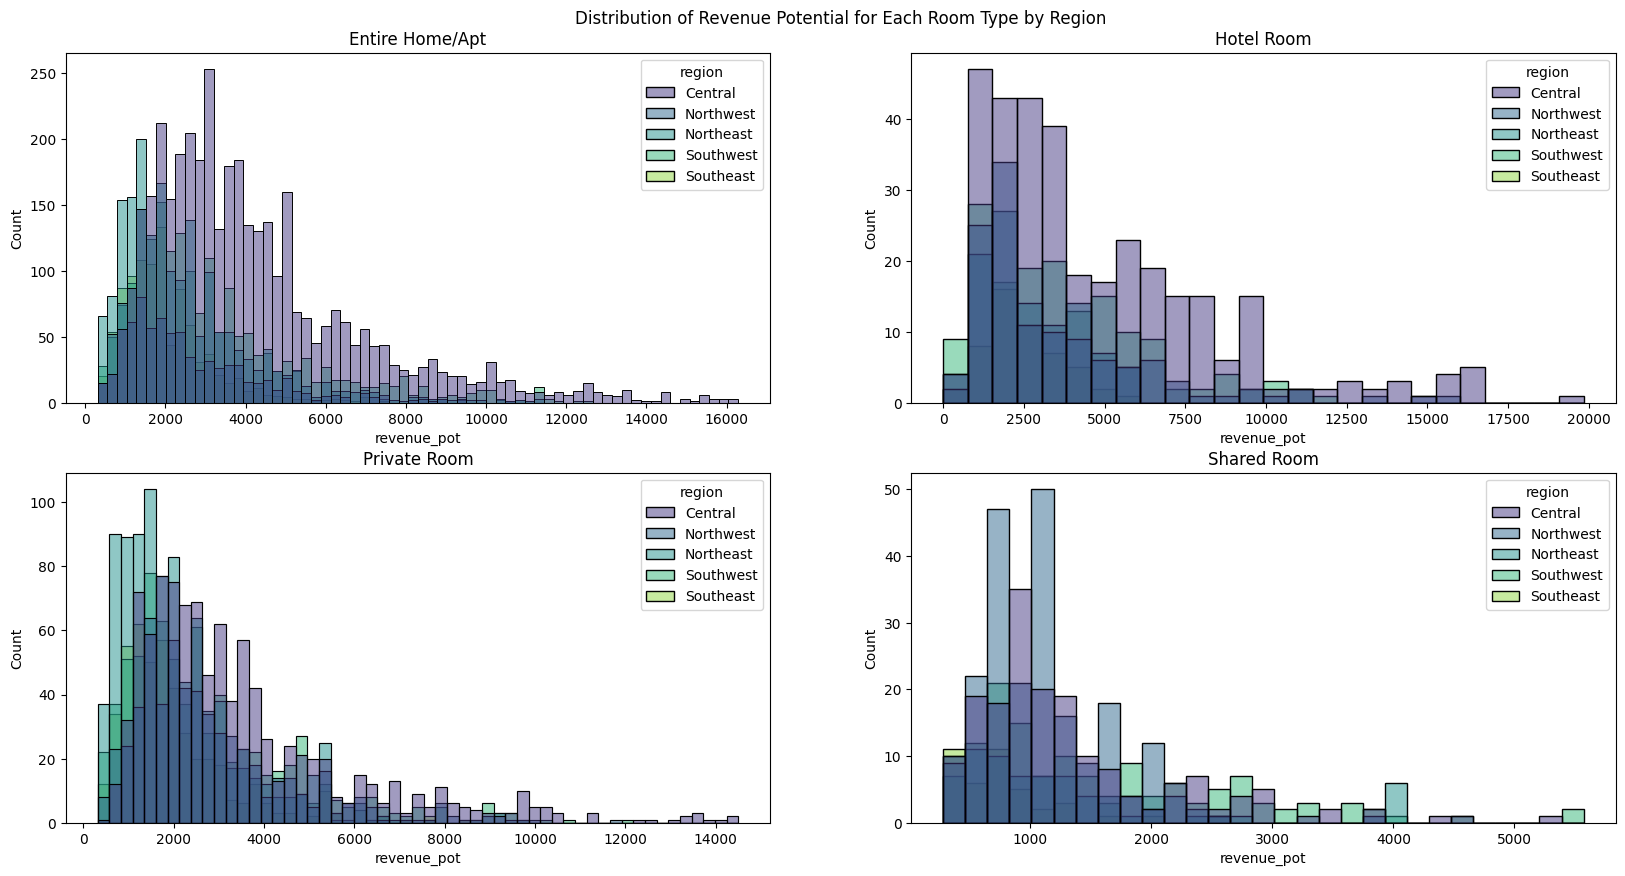

In [684]:
# histplot to see distribution of revenue potential
plt.figure(figsize=(20, 10))
plt.title("Distribution of Revenue Potential for Each Room Type by Region\n")
plt.box(on= None)
plt.axis("off")

plt.subplot(2, 2, 1)
sns.histplot(x = "revenue_pot", data = df3[df3["room_type"] == "Entire home/apt"], hue = "region", palette="viridis")
plt.title("Entire Home/Apt")

plt.subplot(2, 2, 2)
sns.histplot(x = "revenue_pot", data = df3[df3["room_type"] == "Hotel room"], hue = "region", palette="viridis")
plt.title("Hotel Room")

plt.subplot(2, 2, 3)
sns.histplot(x = "revenue_pot", data = df3[df3["room_type"] == "Private room"], hue = "region", palette="viridis")
plt.title("Private Room")

plt.subplot(2, 2, 4)
sns.histplot(x = "revenue_pot", data = df3[df3["room_type"] == "Shared room"], hue = "region", palette="viridis")
plt.title("Shared Room")

Text(0.5, 1.0, 'Median Revenue Potential of Room Types by Region')

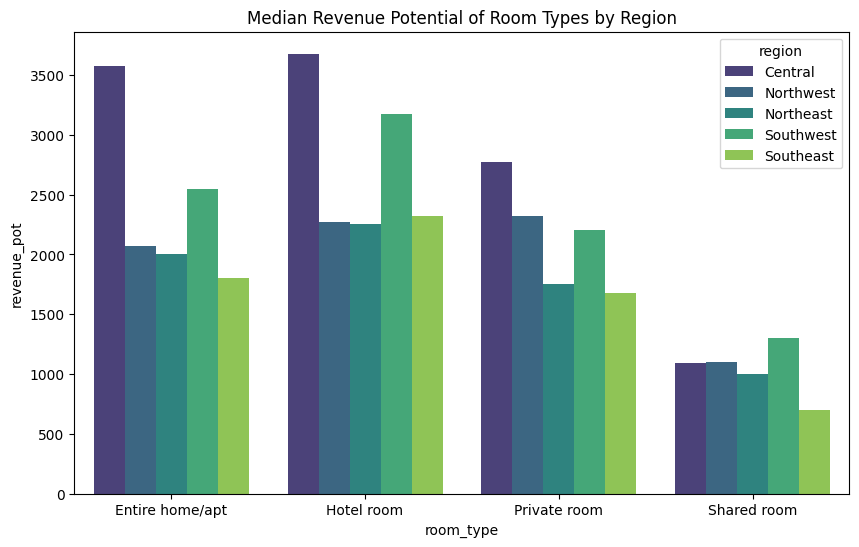

In [685]:
# bar graph showing the difference in revenue potential for each room_type in the different regions
plt.figure(figsize=(10, 6))
sns.barplot(x = "room_type", y = "revenue_pot", data = df3, hue = "region", estimator=np.median, errorbar= None, palette="viridis")
plt.title("Median Revenue Potential of Room Types by Region")